##Phase 2: Exploratory Data Analysis (EDA) and Validation

After initial cleaning, this phase validated the data structure and extracted preliminary insights using automated and manual analysis.


##Work Steps

Data Loading: Loaded the partially cleaned dataset (saved as best_dataset_clean_2.1.pkl) for validation.

Automated Profiling: Utilized specialized libraries (ydata-profiling and sweetviz) to automatically generate comprehensive HTML reports. This diagnosed data quality issues, feature distributions, and initial correlations across all features.

Validation Check: Confirmed that critical columns had minimal missing values (NA) and correct data types (e.g., date formats, numeric standards).

Visual Analysis: Performed manual visualization of key business metrics (e.g., sales Amount distribution, quantity by Category).


##Conclusion & Example Results

The EDA confirmed the success of the initial cleaning phase and provided the first set of actionable business insights and feature validation.

Result: Generated an automated correlation matrix across 93 features, identifying collinearity issues to be addressed in feature selection.

Example: Visual analysis confirmed that the Western Dress category accounted for the highest volume of sales, suggesting it should be a focus for predictive modeling.

# EDA using reporting libraries

In [ ]:
import pandas as pd
df = pd.read_pickle("best_dataset_clean_2.1.pkl")

In [ ]:
df.shape

(130426, 32)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130426 entries, 0 to 130425
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   fulfilment            129002 non-null  category
 1   ship-service-level    129002 non-null  category
 2   category              129002 non-null  category
 3   size                  130426 non-null  category
 4   asin                  129002 non-null  string  
 5   courier_status        122130 non-null  category
 6   currency              121204 non-null  string  
 7   amount                121204 non-null  float64 
 8   ship-state            128969 non-null  string  
 9   ship-postal-code      128969 non-null  Int64   
 10  ship-country          130393 non-null  category
 11  b2b                   129002 non-null  boolean 
 12  day                   130426 non-null  int64   
 13  month                 130426 non-null  category
 14  weekday               130426 non-nul

# Data Protocol

In [ ]:
from itertools import zip_longest

# Identify column types by dtype
numeric_cols = df.select_dtypes(include=['int64', 'Int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include='category').columns.tolist()
string_cols = df.select_dtypes(include=['string', 'object']).columns.tolist()
boolean_cols = df.select_dtypes(include=['bool', 'boolean']).columns.tolist()

# Build a combined summary table for column types
columns_summary = pd.DataFrame(
    list(zip_longest(numeric_cols, categorical_cols, string_cols, boolean_cols)),
    columns=['Numeric Columns', 'Categorical Columns', 'String Columns', 'Boolean Columns']
)

# Display the summary with empty cells filled as blank
display(columns_summary.fillna(""))


,Numeric Columns,Categorical Columns,String Columns,Boolean Columns
0,amount,fulfilment,asin,b2b
1,ship-postal-code,ship-service-level,currency,weekend
2,day,category,ship-state,fulfilment_by_amazon
3,pcs,size,design_no,amazon_channel
4,gross_amt,courier_status,ship-city_norm,has_promotion
5,stock,ship-country,customer_clean,seller_easy_ship
6,,month,category_stock_norm,
7,,weekday,color_norm,
8,,size_stock,,
9,,status_first_word,,


In [ ]:
import pandas as pd

# Define data types relevant for min/max calculations (to avoid TypeError)
relevant_types = ['int64', 'Int64', 'float64', 'string', 'object']

# Create an ExcelWriter to save multiple sheets into Amazon_Data.xlsx
# Using 'with' ensures the file is properly closed after writing
with pd.ExcelWriter("Amazon_Data.xlsx") as writer:

    # 1. Data types of all columns
    df.dtypes.to_excel(writer, sheet_name='data_type')

    # 2. Maximum values (for relevant columns only)
    df_max = df.select_dtypes(include=relevant_types).max()
    df_max.to_excel(writer, sheet_name='max')

    # 3. Minimum values (for relevant columns only)
    df_min = df.select_dtypes(include=relevant_types).min()
    df_min.to_excel(writer, sheet_name='min')

    # 4. Missing value counts per column
    df.isnull().sum(axis=0).to_excel(writer, sheet_name='NA')

    # 5. Number of unique values per column
    df.nunique().to_excel(writer, sheet_name='unique')

# The Excel file is now saved with all 5 summary sheets.


/tmp/ipython-input-2957268435.py:14: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  df_max = df.select_dtypes(include=relevant_types).max()
/tmp/ipython-input-2957268435.py:18: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  df_min = df.select_dtypes(include=relevant_types).min()


# Descriptive Statistics

Automated reports

In [ ]:
!pip install autoviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from autoviz.AutoViz_Class import AutoViz_Class

# =======================================================
# 1. DataFrame normalization: targeted handling of missing values (Null)
# =======================================================
df_cleaned = df.copy()

# A. Replace pd.NA and ±inf with np.nan across the entire frame
#    (avoids 'boolean value of NA is ambiguous' errors)
df_cleaned = df_cleaned.replace(pd.NA, np.nan)
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan)

# B. Type-specific handling
for col in df_cleaned.columns:

    # 1. Numeric columns (float, int, Int64)
    #    i = integer, u = unsigned, f = float → cast to standard float64
    if df_cleaned[col].dtype.kind in 'iuf':
        df_cleaned[col] = df_cleaned[col].astype(np.float64)

    # 2. String/Categorical columns (object, category, string[python], etc.)
    elif df_cleaned[col].dtype.kind in 'O' or 'string' in str(df_cleaned[col].dtype) or 'category' in str(df_cleaned[col].dtype):

        # a. Default fill value for NA/NaN
        fill_val = 'MISSING_CATEGORY'

        # b. Convert to str and fillna BEFORE converting to category
        #    (ensures fillna works, then we cast to category)
        df_cleaned[col] = df_cleaned[col].astype(str).fillna(fill_val)

        # c. Convert to categorical dtype
        df_cleaned[col] = df_cleaned[col].astype('category')

    # 3. Boolean columns (boolean, bool)
    elif df_cleaned[col].dtype.kind in 'b':
        # Fill missing values (if any) with False
        df_cleaned[col] = df_cleaned[col].fillna(False)

# =======================================================
# 2. Run AutoViz using the cleaned DataFrame only
# =======================================================
AV = AutoViz_Class()
report = AV.AutoViz(
    filename="",
    dfte=df_cleaned,  # *** must use df_cleaned here ***
    verbose=1
)


Output hidden; open in https://colab.research.google.com to view.

# EDA - Explenatory Data Analysis

In [ ]:
# Descriptive Statistics
df.describe()

,amount,ship-postal-code,day,gross_amt,stock
count,121204.000000,128969.0,130426.000000,122628.000000,130148.000000
mean,648.557393,463977.372624,14.909987,591.239172,68.836194
std,281.193381,191471.003626,8.745781,341.064783,143.420241
min,0.000000,110001.0,1.000000,0.000000,0.000000
25%,449.000000,382421.0,7.000000,399.000000,5.000000
50%,605.000000,500033.0,15.000000,569.000000,15.000000
75%,788.000000,600024.0,22.000000,771.000000,68.000000
max,5584.000000,989898.0,31.000000,9745.000000,1234.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

# Target Value

Categorial 2 classes

/tmp/ipython-input-2709417267.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.countplot(x="status", data=df, palette="Set2")


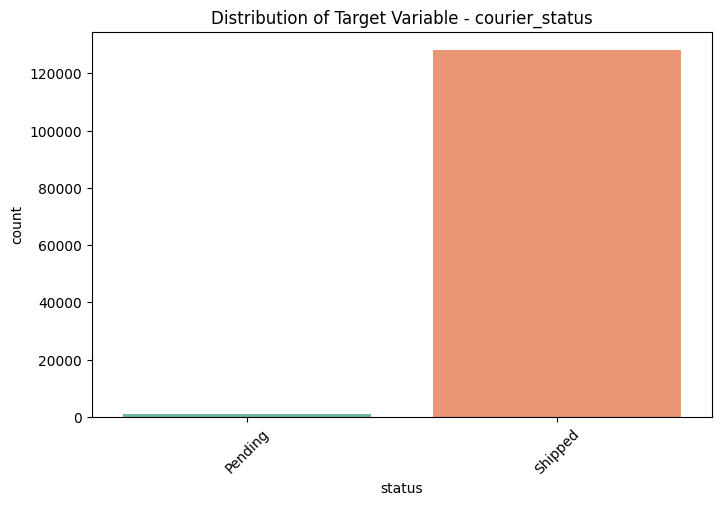

In [ ]:
# ==============================================
# Target Variable Distribution - status
# ==============================================
plt.figure(figsize=(8,5))
sb.countplot(x="status", data=df, palette="Set2")
plt.title("Distribution of Target Variable - status")
plt.xticks(rotation=45)
plt.show()


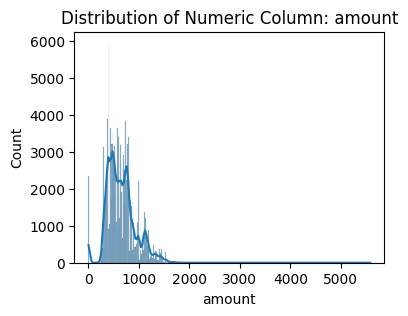

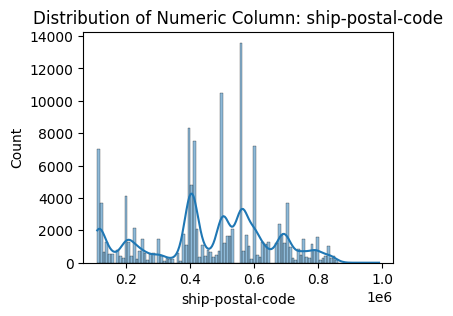

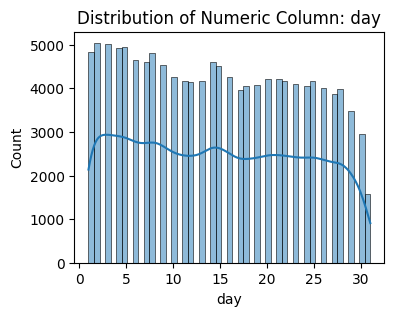

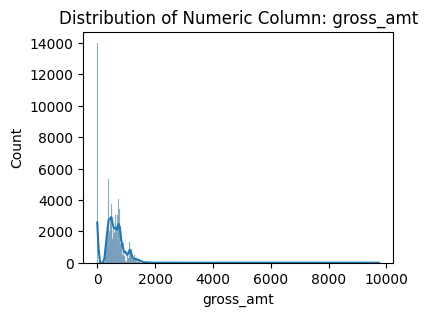

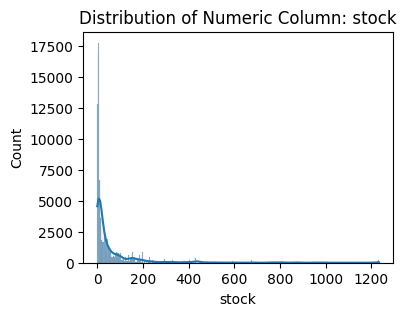

In [ ]:
# ==============================================
# Numeric Columns Visualization
# ==============================================
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(4,3))
    sb.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of Numeric Column: {col}")
    plt.show()


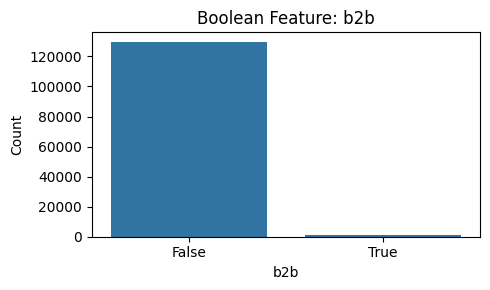

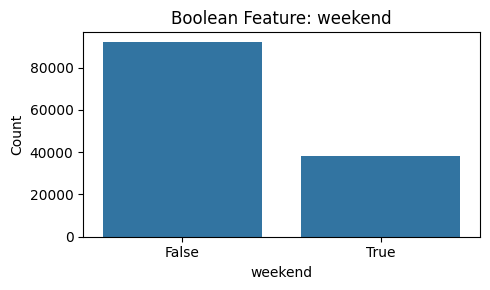

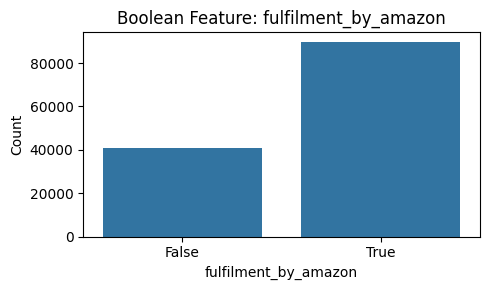

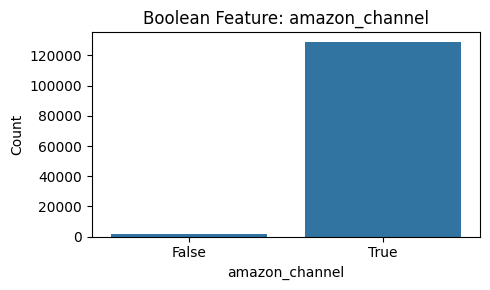

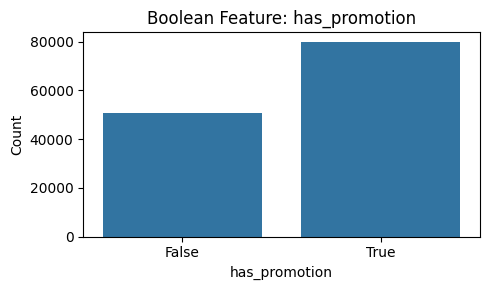

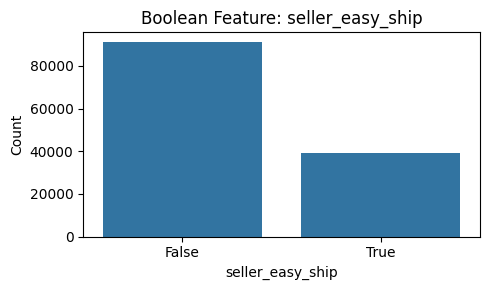

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# === 1) Clean base (your block, with a small guard for np/pd already above) ===
if 'df_cleaned' not in locals() and 'df_cleaned' not in globals():
    df_cleaned = df.copy().replace(pd.NA, np.nan)
    # normalize pandas nullable boolean dtype to pure bool
    bool_cols_full = df_cleaned.select_dtypes(include=["bool", "boolean"]).columns
    for col in bool_cols_full:
        df_cleaned[col] = df_cleaned[col].fillna(False).astype(bool)
else:
    pass

df_to_use = df_cleaned

# === 2) Define boolean_cols ===
# Option A: רק עמודות שהטיפוס שלהן בוליאני
boolean_cols = df_to_use.select_dtypes(include=["bool", "boolean"]).columns.tolist()

# (לא חובה) Option B: הרחבה—לזהות גם עמודות בינאריות שהן לא bool אמיתי
# לדוגמה 0/1, 'yes'/'no', 'true'/'false', 'y'/'n'
if not boolean_cols:
    candidates = []
    for c in df_to_use.columns:
        s = df_to_use[c]
        # דילוג על עמודות מספריות רציפות
        if pd.api.types.is_numeric_dtype(s):
            uniq = pd.unique(s.dropna())
            # בינארי מספרי 0/1
            if set(pd.Series(uniq).astype(float, errors='ignore')) <= {0, 1}:
                candidates.append(c)
        else:
            # בינארי טקסטואלי נפוץ
            s_norm = s.astype("string").str.strip().str.lower()
            uniq = set(s_norm.dropna().unique())
            yesno = {"yes","no"}
            truefalse = {"true","false"}
            yn = {"y","n"}
            if len(uniq) <= 3 and (uniq <= yesno or uniq <= truefalse or uniq <= yn or uniq <= {"0","1"}):
                candidates.append(c)

    # המרה רכה לבוליאני עבור מועמדים טקסטואליים
    for c in candidates:
        s = df_to_use[c]
        if not pd.api.types.is_bool_dtype(s):
            s_norm = s.astype("string").str.strip().str.lower()
            mapped = s_norm.map({
                "true": True, "yes": True, "y": True, "1": True,
                "false": False, "no": False, "n": False, "0": False
            })
            # אם ההמרה הצליחה ברוב הערכים—ניקח
            if mapped.notna().mean() >= 0.9:
                df_to_use[c] = mapped.fillna(False).astype(bool)

    # עדכון סופי אחרי ההמרות
    boolean_cols = df_to_use.select_dtypes(include=["bool", "boolean"]).columns.tolist()

# === 3) Safety: אם אין מה לשרטט, נצא בנימוס ===
if not boolean_cols:
    print("No boolean-like columns found to plot.")
else:
    # === 4) Plot ===
    for col in boolean_cols:
        plt.figure(figsize=(5, 3))
        sb.countplot(x=col, data=df_to_use)
        plt.title(f"Boolean Feature: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


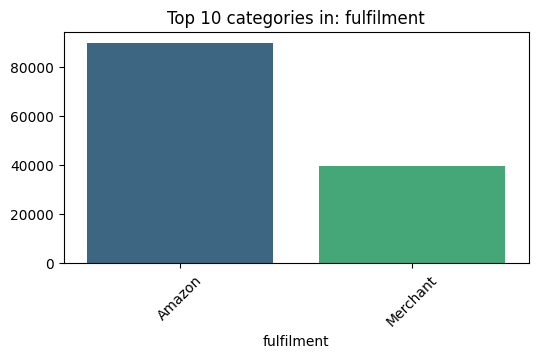

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


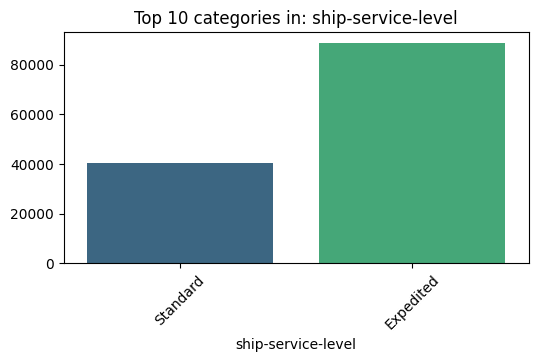

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


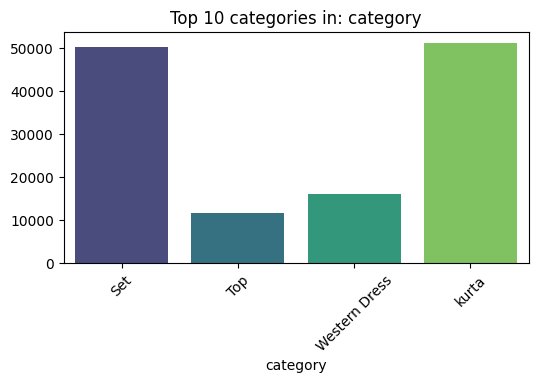

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


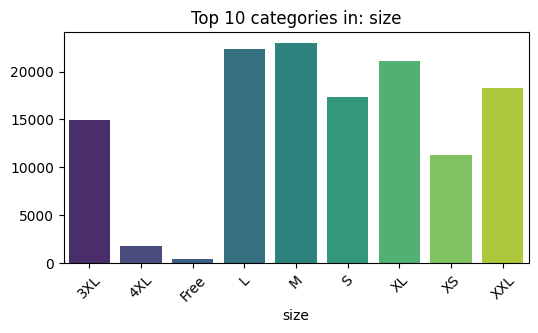

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


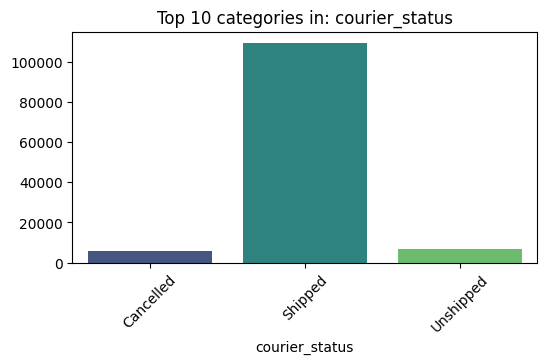

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


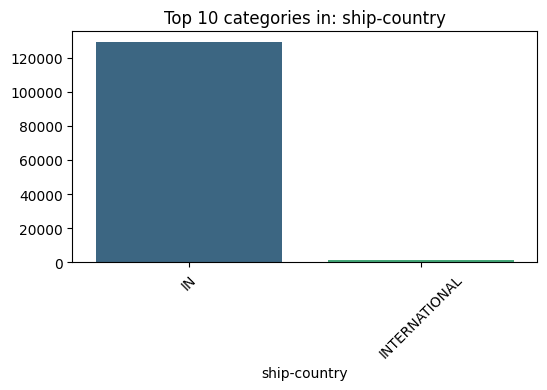

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


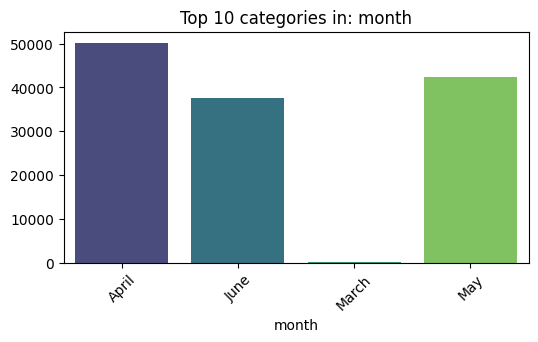

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


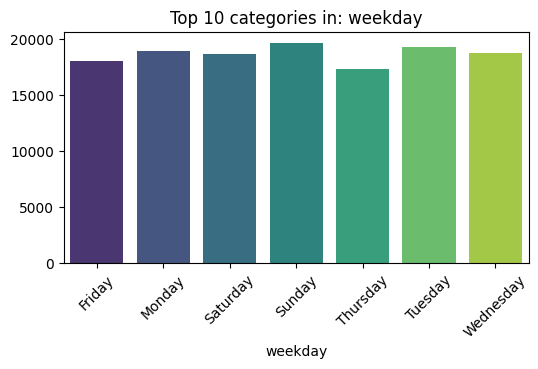

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


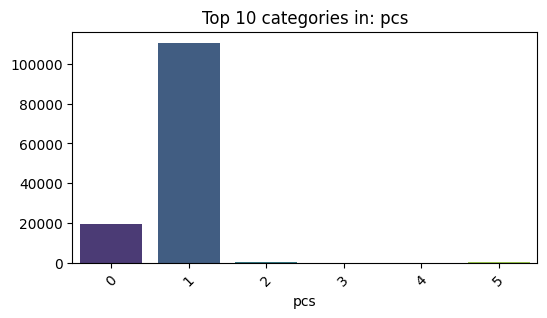

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


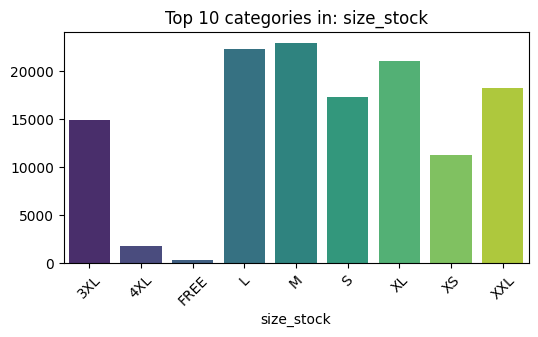

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


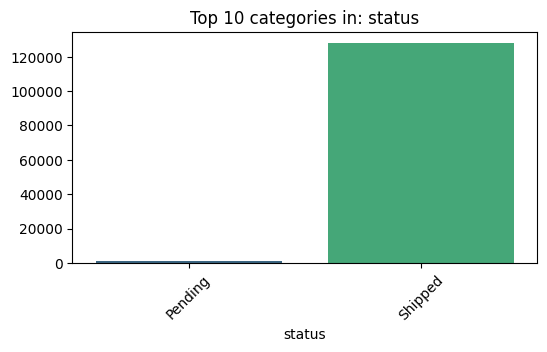

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


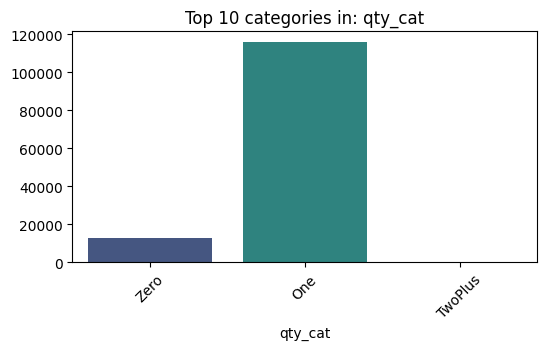

/tmp/ipython-input-236013521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")


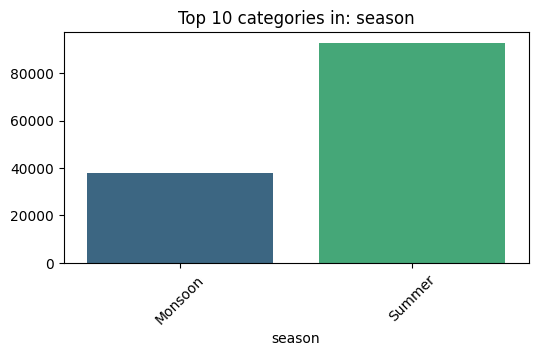

In [ ]:
# ==============================================
# Categorical Columns Visualization
# ==============================================
cat_cols = df.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    plt.figure(figsize=(6,3))
    top_vals = df[col].value_counts().head(10)
    sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")
    plt.title(f"Top 10 categories in: {col}")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# Convert numeric columns before performing calculations
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df["pcs"] = pd.to_numeric(df["pcs"], errors="coerce")

# Perform groupby aggregation by category
category_stats = (
    df.groupby("category", observed=True)
    .agg(
        total_amount=("amount", "sum"),     # total sales amount per category
        average_amount=("amount", "mean"),  # average sales amount per category
        total_units=("pcs", "sum")          # total number of units sold
    )
    .round(2)
    .sort_values("total_amount", ascending=False)  # sort descending by total amount
)

# Display summarized statistics per category
print(category_stats)


               total_amount  average_amount  total_units
category                                                
Set             39204124.03          833.39        42489
kurta           22230685.12          463.22        43379
Western Dress   11366740.67          751.57        13575
Top              5806200.48          525.64        10067


# Categorial Data

# Histograms for continues numbers

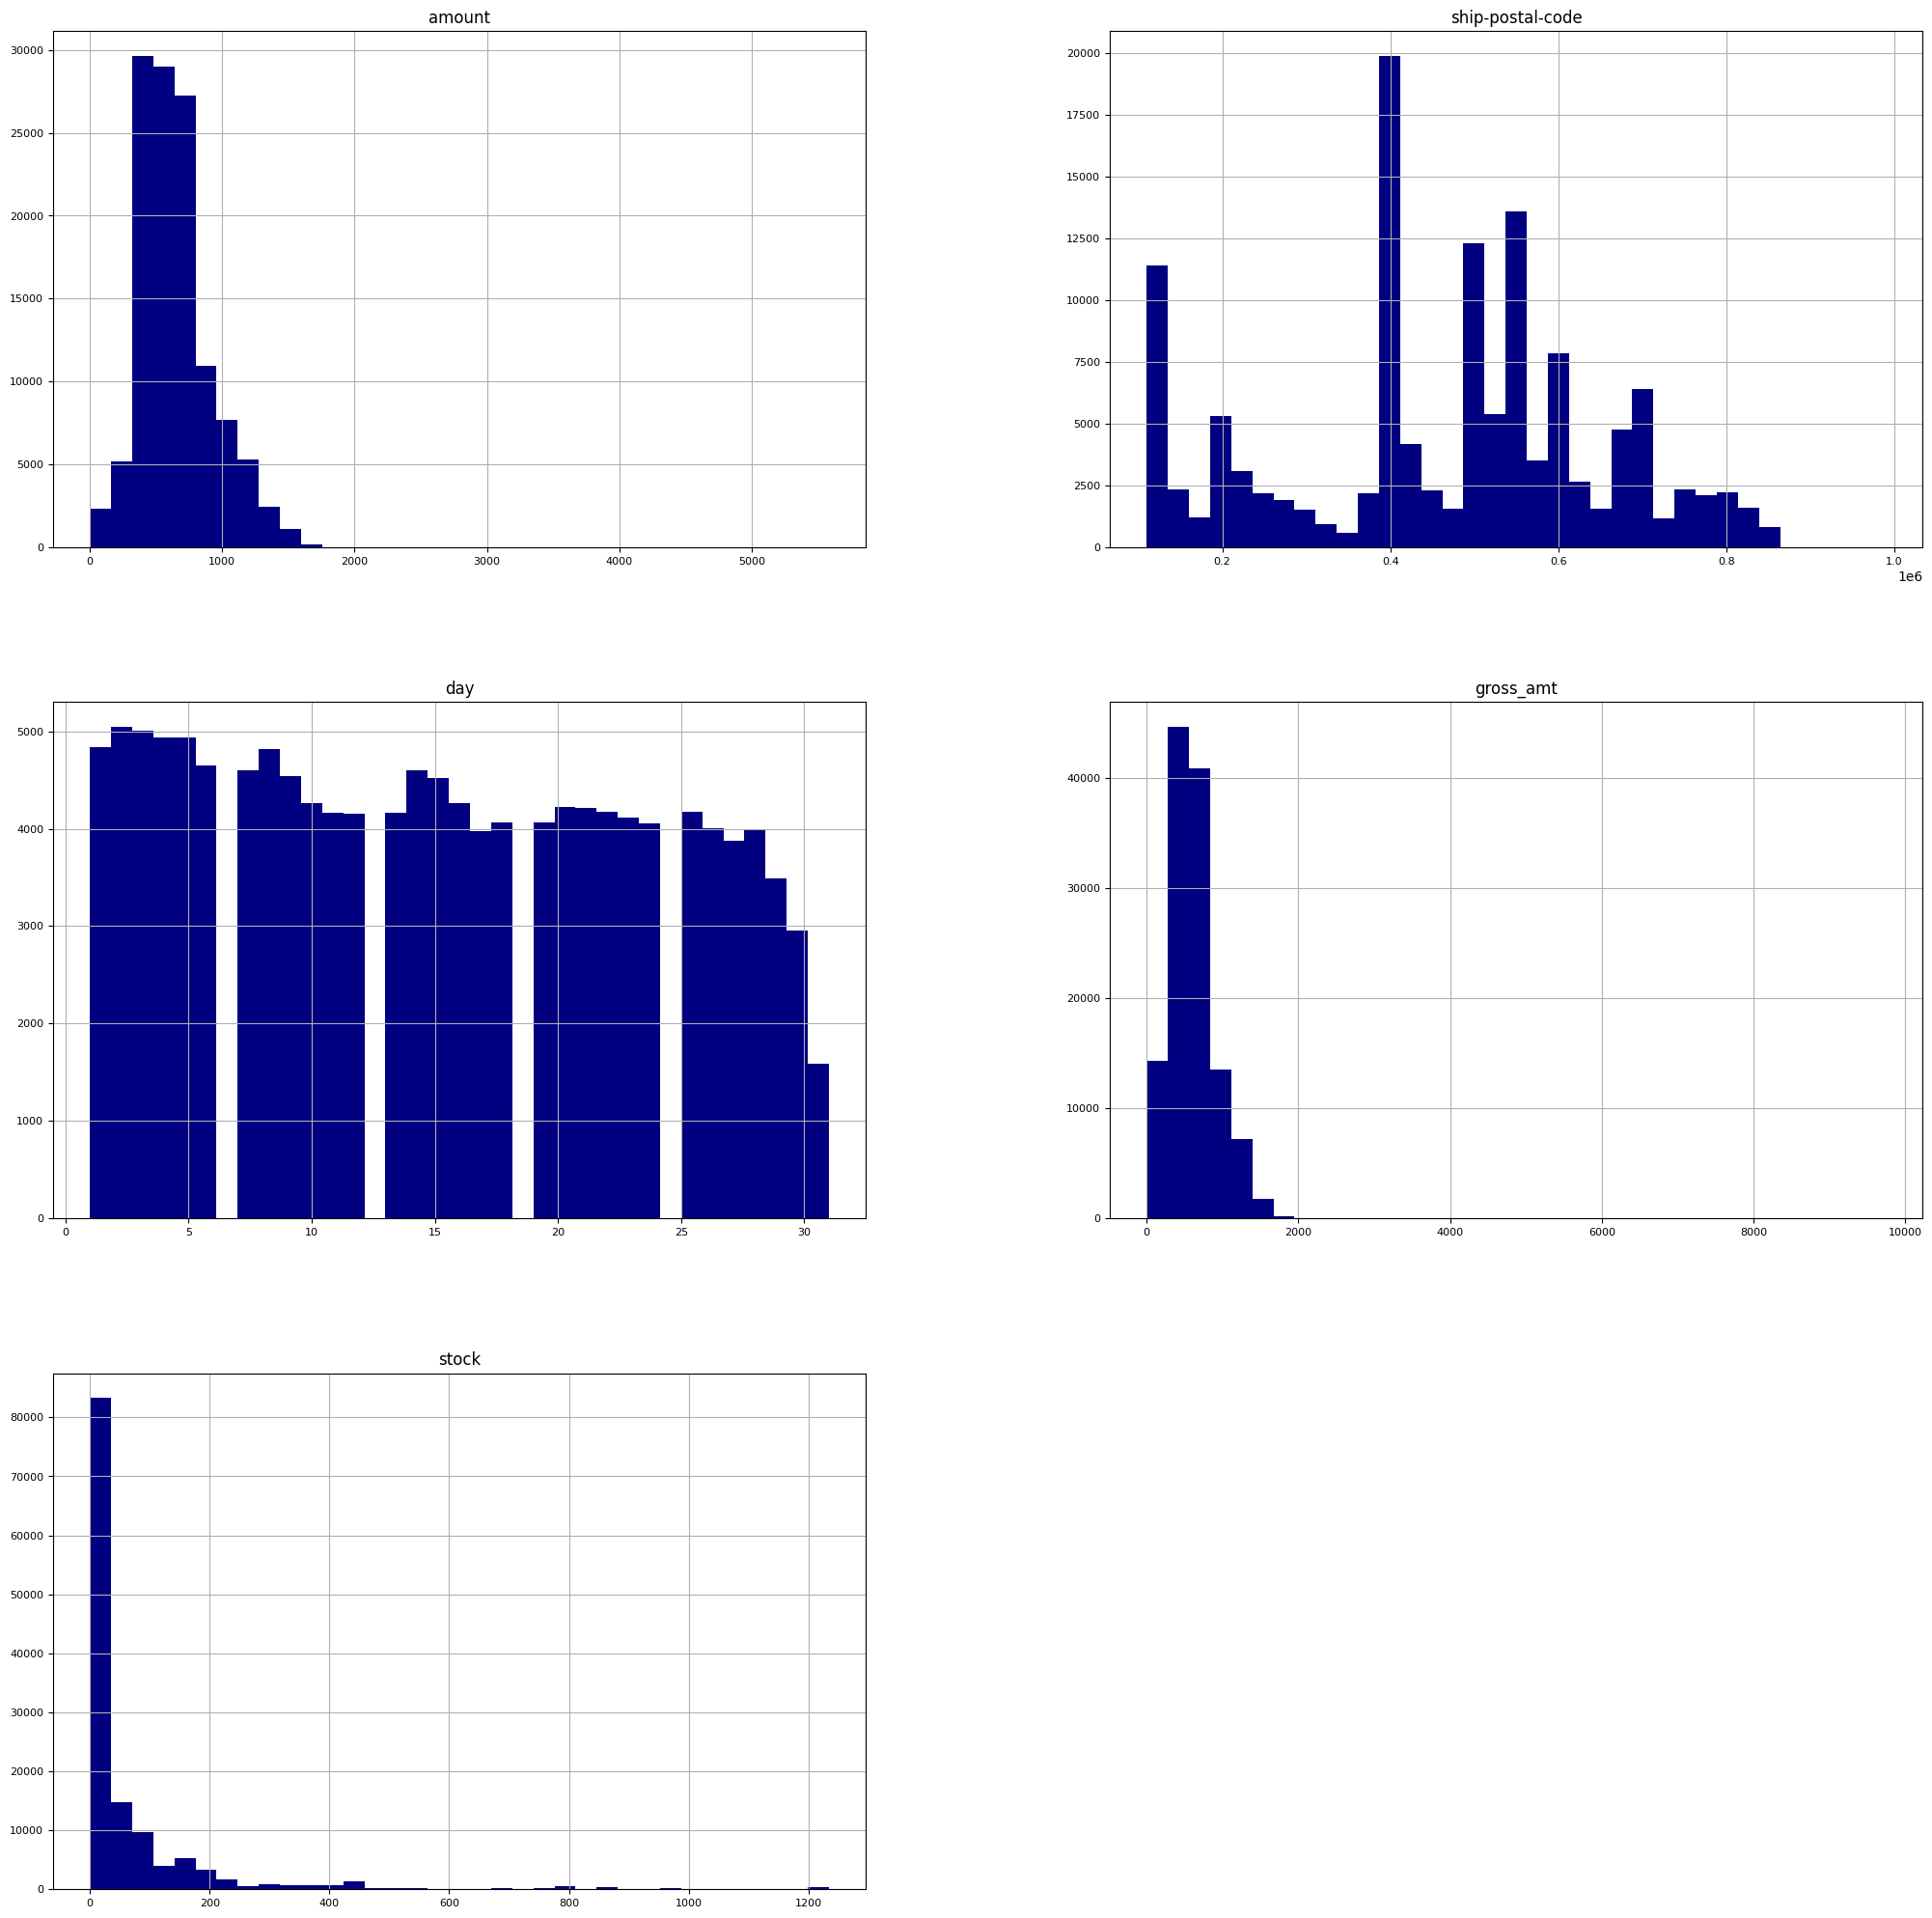

In [ ]:
# Assumption: df_cleaned is the cleaned DataFrame we prepared earlier
df_to_use = df_cleaned

# 1. Select only numeric columns from the DataFrame
numeric_df = df_to_use.select_dtypes(include=np.number)

# 2. Plot histograms for all numeric columns
# The semicolon at the end suppresses extra Matplotlib output in notebooks
numeric_df.hist(
    figsize=(25, 25),  # set overall figure size
    bins=35,           # number of bins per histogram
    xlabelsize=8,      # X-axis label size
    ylabelsize=8,      # Y-axis label size
    color="navy"       # histogram color
);


# Skewness

In [ ]:
# Define a function to highlight skewness values visually
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'  # for highly positive skew (> 1)
    negative = 'background-color: hotpink;'             # for highly negative skew (< -1)
    default = ''                                        # no formatting otherwise
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    else:
        return default

# Compute skewness for each numeric column and apply conditional highlighting
pd.DataFrame(numeric_df.skew(), columns=['skewness']) \
  .sort_values(by='skewness', ascending=False) \
  .style.applymap(highlight)


/tmp/ipython-input-3880808316.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  pd.DataFrame(numeric_df.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)


,skewness
stock,4.401099
gross_amt,1.075710
amount,0.885518
day,0.093790
ship-postal-code,-0.258399


Most continus data are normaly distributed

# Correlation

In [ ]:
#The Pearson correlation measures the linear relationship between two continuous variables

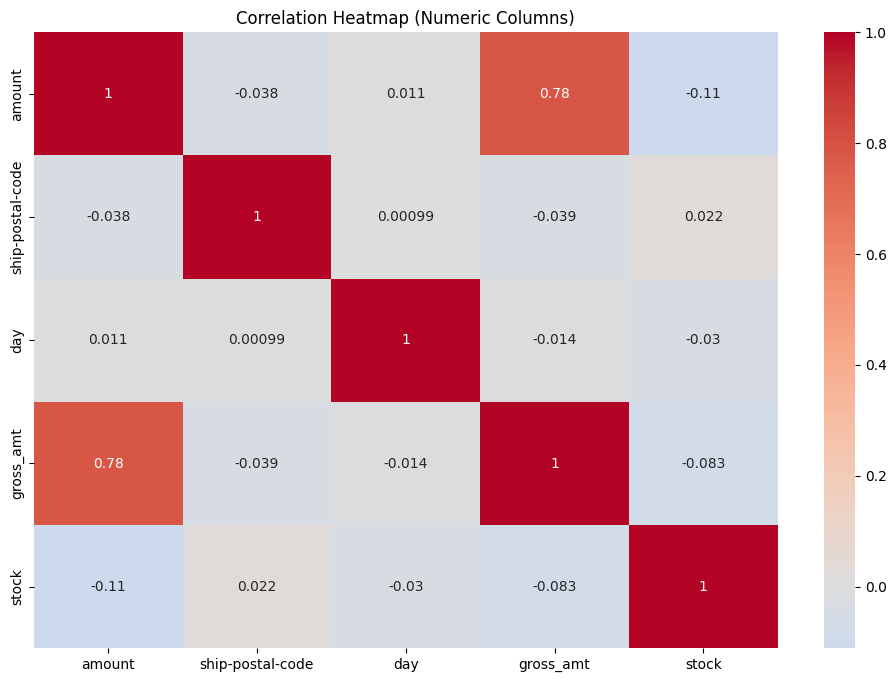

In [ ]:
# ==============================================
# 9. Correlation Heatmap for Numeric Variables
# ==============================================
plt.figure(figsize=(12,8))
sb.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Columns)")
plt.show()

In [ ]:
df.corr(numeric_only=True)


,amount,ship-postal-code,b2b,day,weekend,pcs,gross_amt,stock,fulfilment_by_amazon,amazon_channel,has_promotion,seller_easy_ship
amount,1.000000,-0.038202,0.015706,0.011321,0.003169,0.004914,0.782427,-0.111257,0.004918,NaN,0.126005,-0.004918
ship-postal-code,-0.038202,1.000000,-0.035650,0.000986,-0.015699,-0.016229,-0.038766,0.021787,0.001846,0.011304,0.006115,-0.001846
b2b,0.015706,-0.035650,1.000000,0.006725,-0.003861,0.014169,0.018568,-0.002718,-0.005090,0.002557,0.002131,0.005090
day,0.011321,0.000986,0.006725,1.000000,-0.003741,-0.019214,-0.013959,-0.030033,-0.042975,0.014617,0.022403,0.047149
weekend,0.003169,-0.015699,-0.003861,-0.003741,1.000000,0.010194,0.003235,-0.013754,0.010792,0.042812,0.018133,-0.000221
pcs,0.004914,-0.016229,0.014169,-0.019214,0.010194,1.000000,0.592646,-0.005198,0.053153,-0.060648,0.460846,-0.072849
gross_amt,0.782427,-0.038766,0.018568,-0.013959,0.003235,0.592646,1.000000,-0.082938,0.045260,-0.131135,0.302932,-0.076203
stock,-0.111257,0.021787,-0.002718,-0.030033,-0.013754,-0.005198,-0.082938,1.000000,0.134781,0.022178,-0.078574,-0.130463
fulfilment_by_amazon,0.004918,0.001846,-0.005090,-0.042975,0.010792,0.053153,0.045260,0.134781,1.000000,0.143751,-0.252534,-0.974650
amazon_channel,NaN,0.011304,0.002557,0.014617,0.042812,-0.060648,-0.131135,0.022178,0.143751,1.000000,0.137686,0.071955


<Axes: >

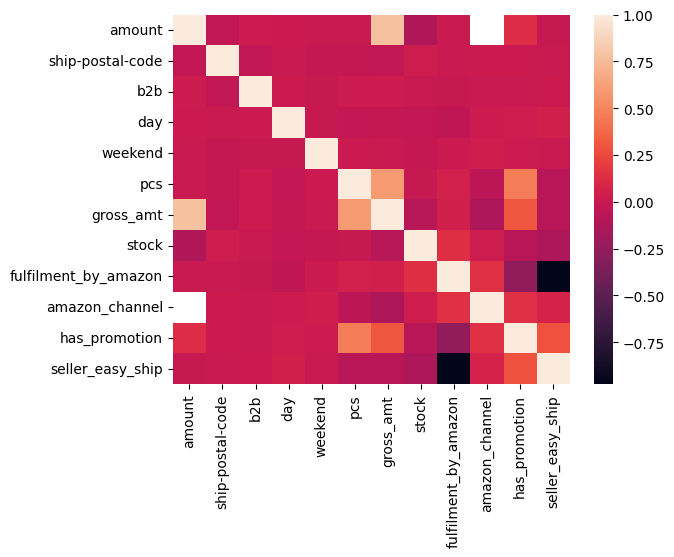

In [ ]:
sb.heatmap(df.corr(numeric_only=True))

In [ ]:
# Calculate Spearman correlation between all numeric columns
# Spearman method measures monotonic relationships (rank-based correlation)
df.corr(method='spearman', numeric_only=True)



,amount,ship-postal-code,b2b,day,weekend,pcs,gross_amt,stock,fulfilment_by_amazon,amazon_channel,has_promotion,seller_easy_ship
amount,1.000000,-0.045585,0.012664,0.017339,0.005004,0.007918,0.827672,-0.072592,-0.002178,NaN,0.140728,0.002178
ship-postal-code,-0.045585,1.000000,-0.036546,0.000477,-0.015368,-0.016111,-0.044442,0.034483,0.002816,0.025468,0.015588,-0.002816
b2b,0.012664,-0.036546,1.000000,0.007168,-0.003861,0.014169,0.016296,-0.004918,-0.005090,0.002557,0.002131,0.005090
day,0.017339,0.000477,0.007168,1.000000,-0.004017,-0.020919,-0.004615,-0.007616,-0.045832,0.014387,0.022994,0.049998
weekend,0.005004,-0.015368,-0.003861,-0.004017,1.000000,0.011703,0.006706,-0.015991,0.010792,0.042812,0.018133,-0.000221
pcs,0.007918,-0.016111,0.014169,-0.020919,0.011703,1.000000,0.500188,-0.006630,0.058317,-0.036086,0.472924,-0.072351
gross_amt,0.827672,-0.044442,0.016296,-0.004615,0.006706,0.500188,1.000000,-0.058035,0.039582,-0.084855,0.307891,-0.059710
stock,-0.072592,0.034483,-0.004918,-0.007616,-0.015991,-0.006630,-0.058035,1.000000,0.201503,0.018244,-0.106512,-0.198690
fulfilment_by_amazon,-0.002178,0.002816,-0.005090,-0.045832,0.010792,0.058317,0.039582,0.201503,1.000000,0.143751,-0.252534,-0.974650
amazon_channel,NaN,0.025468,0.002557,0.014387,0.042812,-0.036086,-0.084855,0.018244,0.143751,1.000000,0.137686,0.071955


# t-test

In [ ]:
df

,fulfilment,ship-service-level,category,size,asin,courier_status,currency,amount,ship-state,ship-postal-code,...,fulfilment_by_amazon,amazon_channel,qty_cat,ship-city_norm,has_promotion,seller_easy_ship,customer_clean,category_stock_norm,color_norm,season
0,Merchant,Standard,Western Dress,M,B09SDY8DCT,Shipped,INR,761.0,TAMIL NADU,600026,...,False,True,One,CHENNAI,True,True,<NA>,KURTA,Green,Summer
1,Amazon,Expedited,Set,L,B09PN4P12Y,Cancelled,<NA>,NaN,TELANGANA,500020,...,True,True,Zero,HYDERABAD,False,False,<NA>,SET,Black,Summer
2,Amazon,Expedited,Set,M,B099NDNDD4,Shipped,INR,519.0,KARNATAKA,560085,...,True,True,One,BENGALURU,True,False,<NA>,SET,Cream,Summer
3,Amazon,Expedited,Set,S,B09QJ577FG,Shipped,INR,1165.0,MAHARASHTRA,421302,...,True,True,One,BHIWANDI,True,False,<NA>,SET,Pink,Summer
4,Amazon,Expedited,kurta,L,B08N19RF53,Shipped,INR,358.0,BIHAR,800013,...,True,True,One,PATNA,False,False,<NA>,KURTA,Orange,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130421,Amazon,Expedited,Set,XL,B08HK5C45Z,Unshipped,INR,668.0,KARNATAKA,560085,...,True,True,One,BANGALORE,False,False,<NA>,SET,Red,Monsoon
130422,Amazon,Expedited,Set,S,B07Q2M4W2P,Shipped,INR,612.0,BIHAR,800002,...,True,True,One,PATNA,True,False,<NA>,SET,Mustard,Monsoon
130423,Amazon,Expedited,Top,XL,B092CZVBCR,Unshipped,INR,423.0,KARNATAKA,560026,...,True,True,One,BENGALURU,False,False,<NA>,TOP,Green,Monsoon
130424,Merchant,Standard,kurta,XL,B09K3YYJP5,Unshipped,INR,301.0,UTTAR PRADESH,201102,...,False,True,One,OTHER,True,True,<NA>,KURTA,Green,Monsoon


In [ ]:
!pip install scipy
import scipy.stats as stats
import seaborn as sns


--- T-test (b2b vs amount) ---
T-statistic: -4.5920
P-value: 0.00001
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


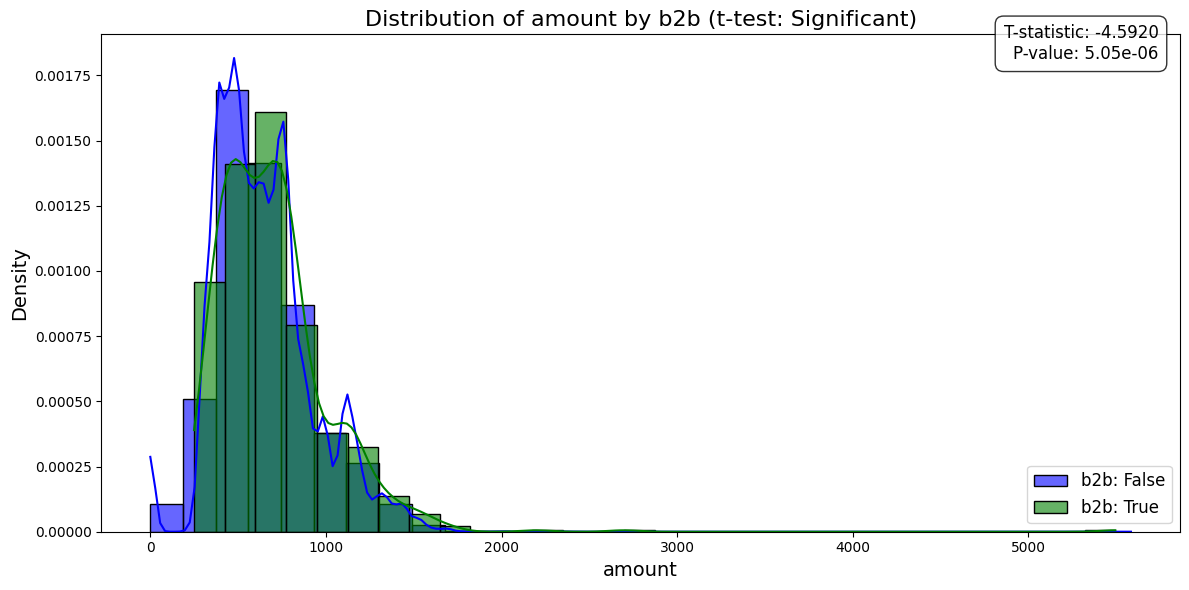


--- T-test (status vs amount) ---
T-statistic: -1.6536
P-value: 0.09854
Result: Not Significant difference in mean amount (P < 0.05)
--------------------------------------------------


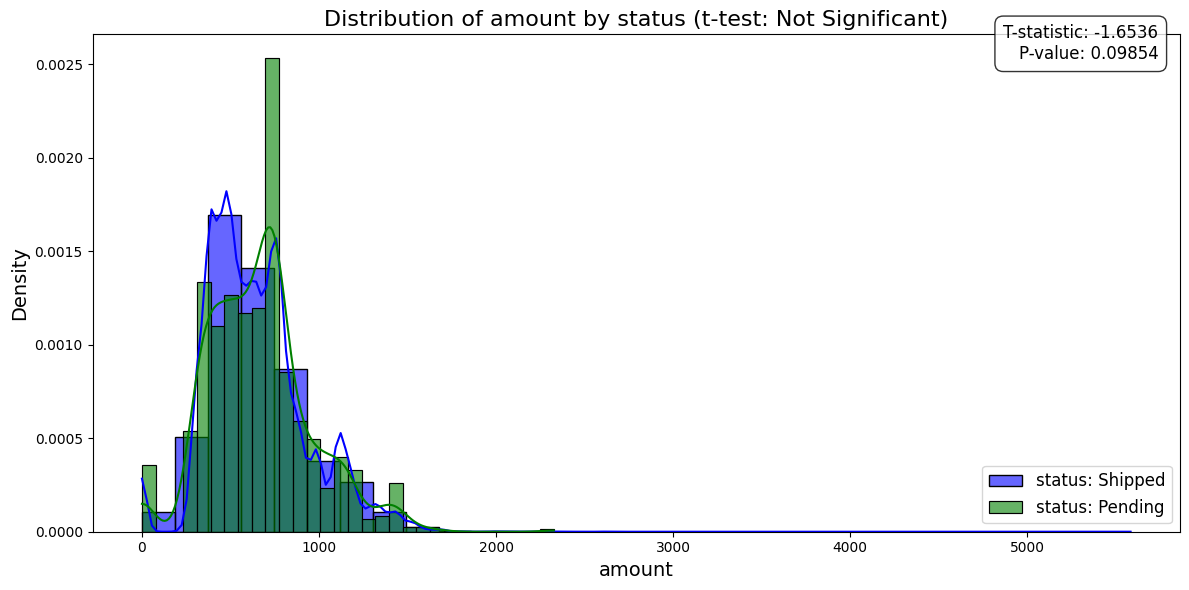


--- T-test (fulfilment vs amount) ---
T-statistic: -1.7162
P-value: 0.08613
Result: Not Significant difference in mean amount (P < 0.05)
--------------------------------------------------


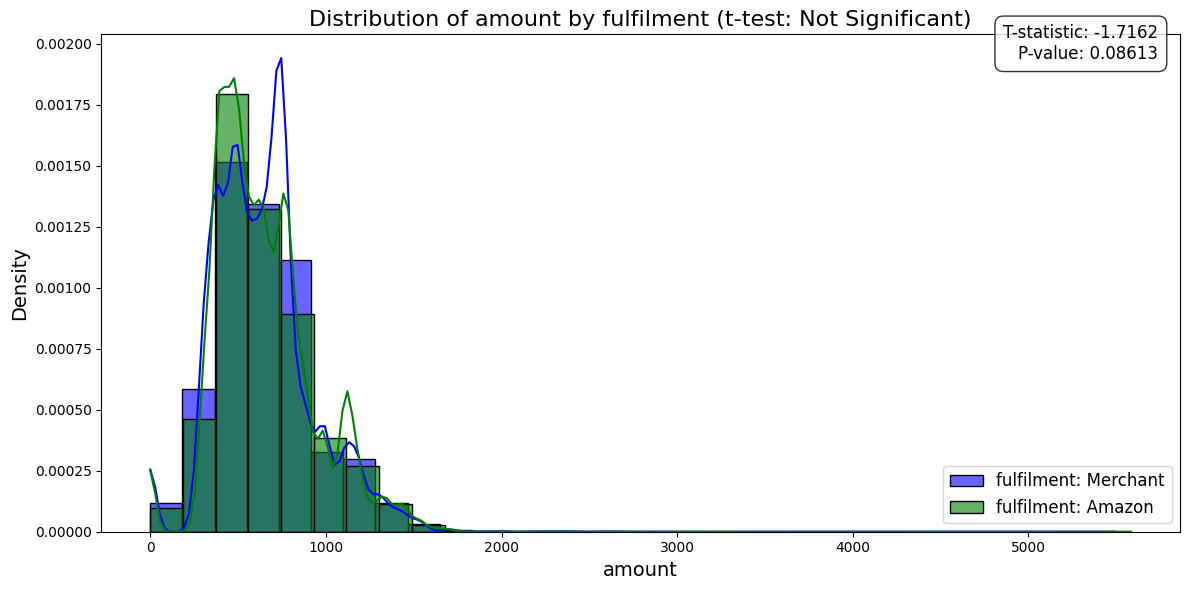


--- T-test (ship-service-level vs amount) ---
T-statistic: -13.6308
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


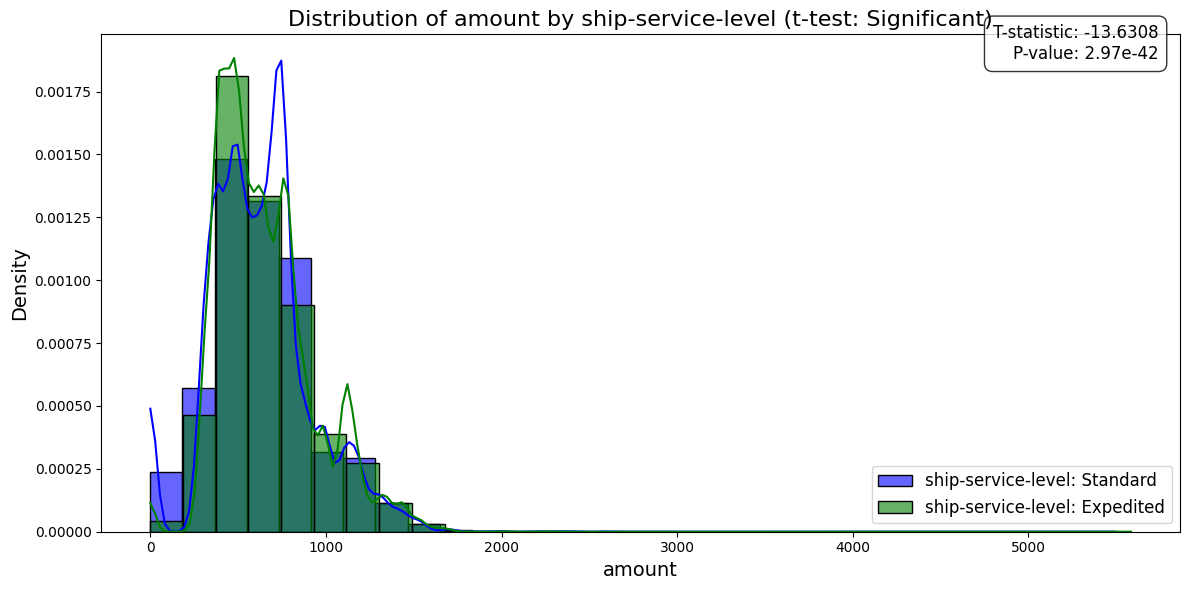


--- T-test (has_promotion vs amount) ---
T-statistic: 43.6728
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


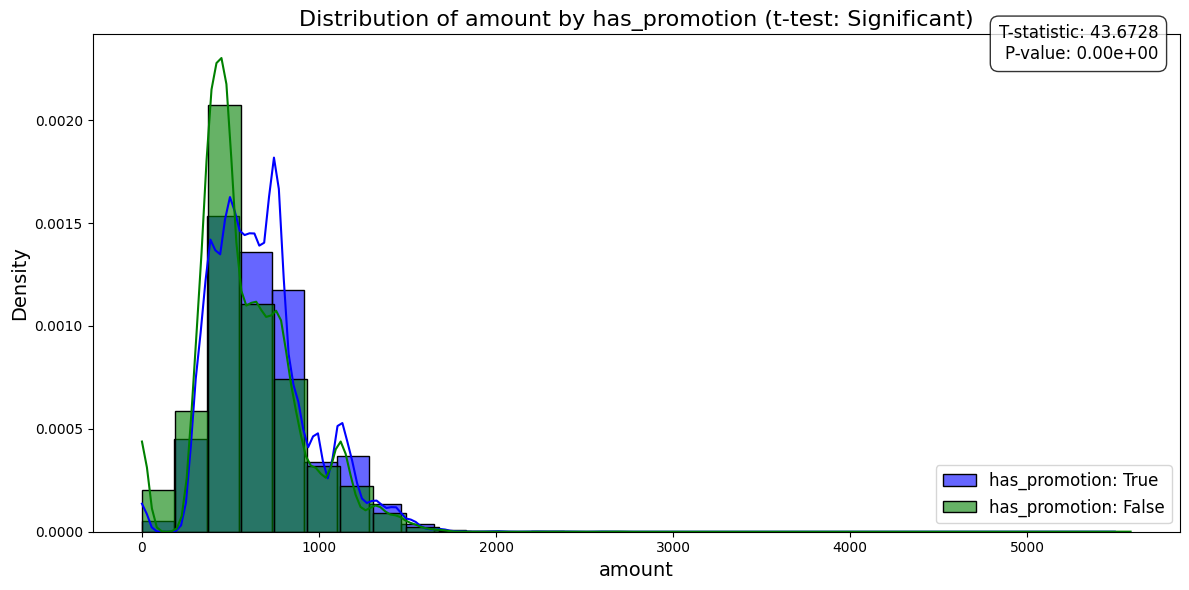


--- T-test (seller_easy_ship vs amount) ---
T-statistic: -1.7162
P-value: 0.08613
Result: Not Significant difference in mean amount (P < 0.05)
--------------------------------------------------


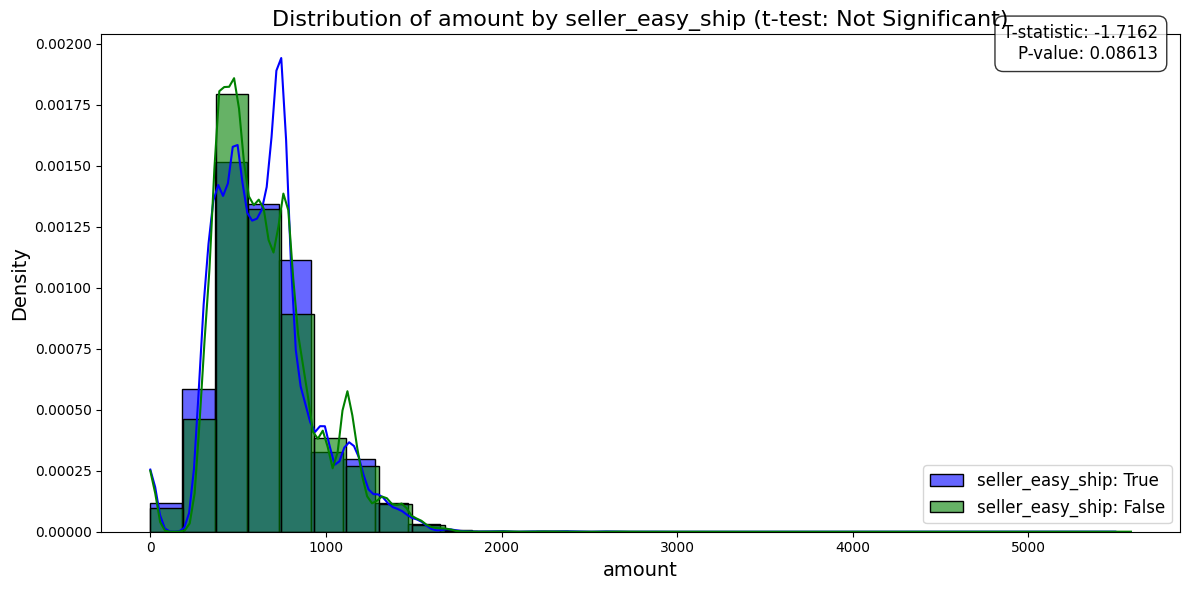

Skipping amazon_channel: Found 1 unique categories (expected 2 for t-test).

--- T-test (fulfilment_by_amazon vs amount) ---
T-statistic: -1.7162
P-value: 0.08613
Result: Not Significant difference in mean amount (P < 0.05)
--------------------------------------------------


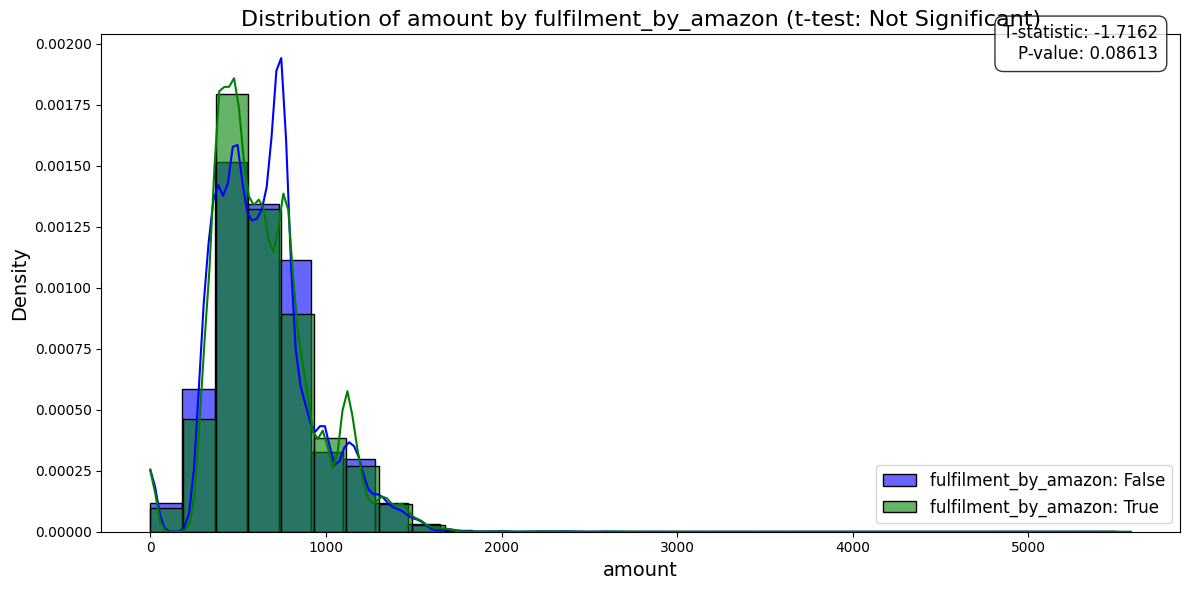

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# -------------------------------------------------------------
# 1. Settings
# -------------------------------------------------------------
# Assumption: 'df' is your working DataFrame (loaded and ready)
df_to_use = df
TARGET_NUMERIC = "amount"
BINARY_COLS = [
    'b2b',
    'status',
    'fulfilment',
    'ship-service-level',
    'has_promotion',
    'seller_easy_ship',
    'amazon_channel',
    'fulfilment_by_amazon'
]

# 2. Build a subset without NA in the target column
# This ensures t-tests are computed on comparable samples
df_test = df_to_use.dropna(subset=[TARGET_NUMERIC])

# -------------------------------------------------------------
# 3. Function: run t-test and plot distributions
# -------------------------------------------------------------
def run_ttest_and_plot(df, numeric_col, binary_col):
    """Run an independent-samples t-test and plot histogram/KDE for a given binary column."""

    # Drop rows with NA in the binary column
    df_clean_specific = df.dropna(subset=[binary_col])

    # Detect the two categories
    categories = df_clean_specific[binary_col].unique()

    if len(categories) != 2:
        print(f"Skipping {binary_col}: Found {len(categories)} unique categories (expected 2 for t-test).")
        return

    # Explicitly unpack the two categories
    cat1, cat2 = list(categories)
    group1 = df_clean_specific[df_clean_specific[binary_col] == cat1][numeric_col]
    group2 = df_clean_specific[df_clean_specific[binary_col] == cat2][numeric_col]

    # Ensure sufficient sample size
    if len(group1) < 2 or len(group2) < 2:
        print(f"Skipping {binary_col}: Not enough samples in one or both groups.")
        return

    # Welch's t-test (unequal variances)
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    # Print results
    print(f"\n--- T-test ({binary_col} vs {numeric_col}) ---")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.5f}")

    is_significant = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Result: {is_significant} difference in mean {numeric_col} (P < 0.05)")
    print("-" * 50)

    # 4. Plot (Histogram + KDE)
    plt.figure(figsize=(12, 6))

    # Overlay both distributions
    sns.histplot(group1, kde=True, color='blue',  label=f'{binary_col}: {cat1}', bins=30, stat='density', alpha=0.6)
    sns.histplot(group2, kde=True, color='green', label=f'{binary_col}: {cat2}', bins=30, stat='density', alpha=0.6)

    # Titles and labels
    title = f'Distribution of {numeric_col} by {binary_col} (t-test: {is_significant})'
    plt.title(title, fontsize=16)
    plt.xlabel(numeric_col, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)

    # Annotate with test statistics
    p_val_display = f"{p_val:.2e}" if p_val < 1e-5 else f"{p_val:.5f}"
    plt.text(
        0.98, 0.95,
        f'T-statistic: {t_stat:.4f}\nP-value: {p_val_display}',
        transform=plt.gca().transAxes,
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()  # display the plot in notebook output

# -------------------------------------------------------------
# 5. Run over all binary columns
# -------------------------------------------------------------
for col in BINARY_COLS:
    run_ttest_and_plot(df_test, TARGET_NUMERIC, col)


T-statistic (amount, shipped vs unshipped): -3.862993
P-value: 0.000112959
n_shipped=109510, mean_shipped=649.0090
n_unshipped=6558, mean_unshipped=662.4895


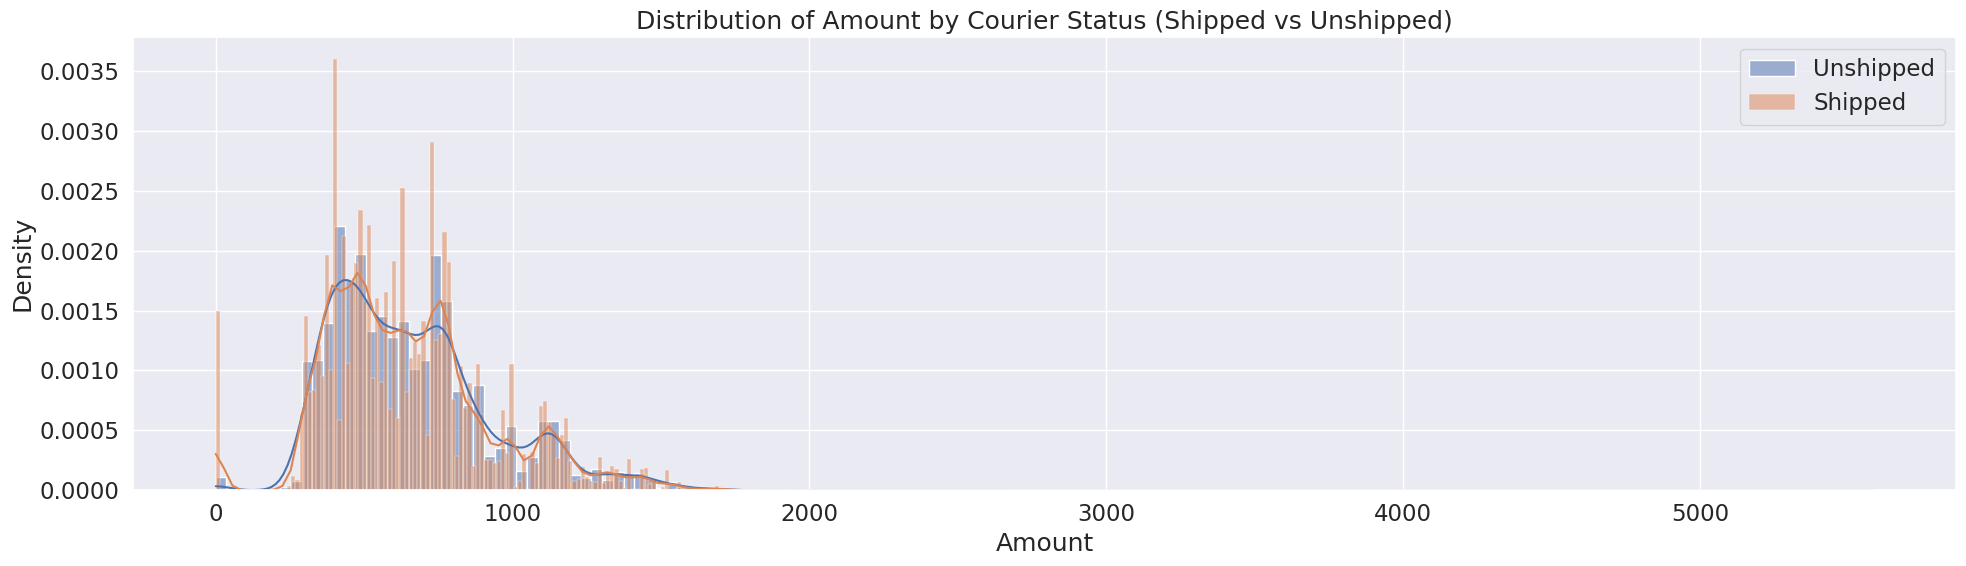

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# --- Normalize courier_status values (trim + lowercase) ---
df["courier_status"] = df["courier_status"].astype("string").str.strip().str.lower()

# --- Pick only shipped vs unshipped ---
mask_two = df["courier_status"].isin(["shipped", "unshipped"])
df2 = df.loc[mask_two, ["courier_status", "amount"]].dropna(subset=["amount"]).copy()

# --- Separate the amount by courier_status ---
amount_shipped   = df2.loc[df2["courier_status"] == "shipped",   "amount"]
amount_unshipped = df2.loc[df2["courier_status"] == "unshipped", "amount"]

# --- Independent samples t-test (Welch) ---
t_stat, p_value = stats.ttest_ind(amount_shipped, amount_unshipped, equal_var=False)

# --- Print results ---
print(f"T-statistic (amount, shipped vs unshipped): {t_stat:.6f}")
print(f"P-value: {p_value:.6g}")
print(f"n_shipped={amount_shipped.size}, mean_shipped={amount_shipped.mean():.4f}")
print(f"n_unshipped={amount_unshipped.size}, mean_unshipped={amount_unshipped.mean():.4f}")

# --- Plot distributions ---
plt.figure(figsize=(20, 6))
sns.histplot(amount_unshipped, kde=True, label="Unshipped", alpha=0.5, stat="density", common_norm=False)
sns.histplot(amount_shipped,   kde=True, label="Shipped",   alpha=0.5, stat="density", common_norm=False)
plt.title("Distribution of Amount by Courier Status (Shipped vs Unshipped)")
plt.xlabel("Amount")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: log-transform if amount is heavily right-skewed ---
# df2["amount_log"] = np.log1p(df2["amount"])
# t_log = stats.ttest_ind(
#     df2.loc[df2["courier_status"]=="shipped","amount_log"],
#     df2.loc[df2["courier_status"]=="unshipped","amount_log"],
#     equal_var=False
# )
# print(f"T-statistic (log1p amount): {t_log.statistic:.6f}, P-value: {t_log.pvalue:.6g}")


# Anova

#F-statistic = Variance Between the groups/Variance within the groups


--- ANOVA (category vs amount) ---
F-statistic: 24123.4980
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


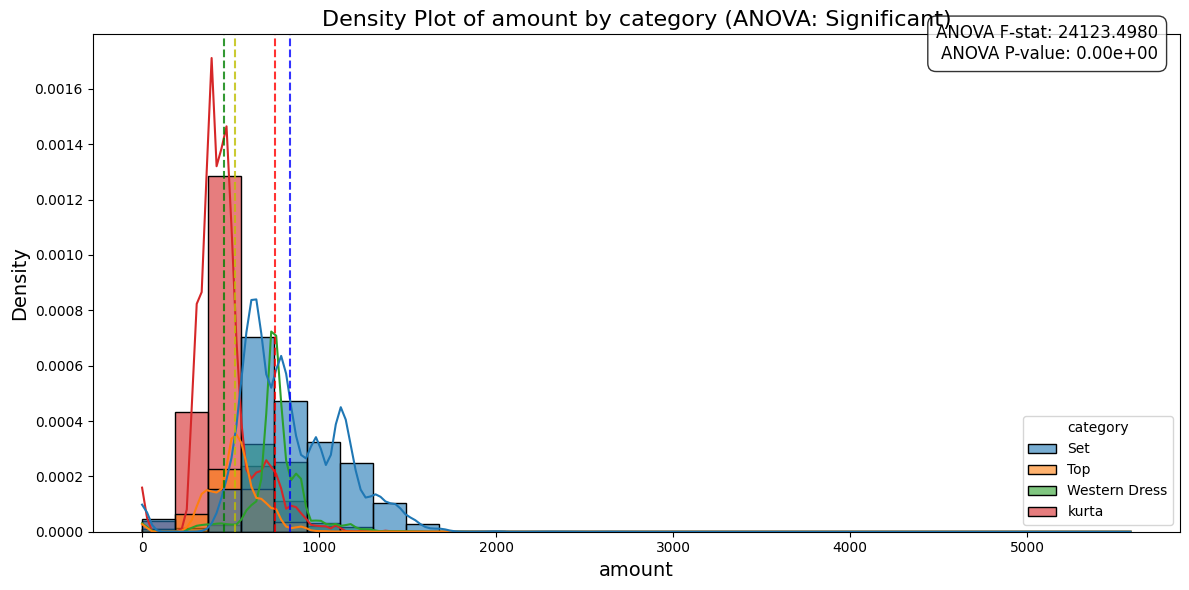

Skipping courier_status: Found only 2 unique categories (ANOVA requires >= 3).

--- ANOVA (size vs amount) ---
F-statistic: 132.5839
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


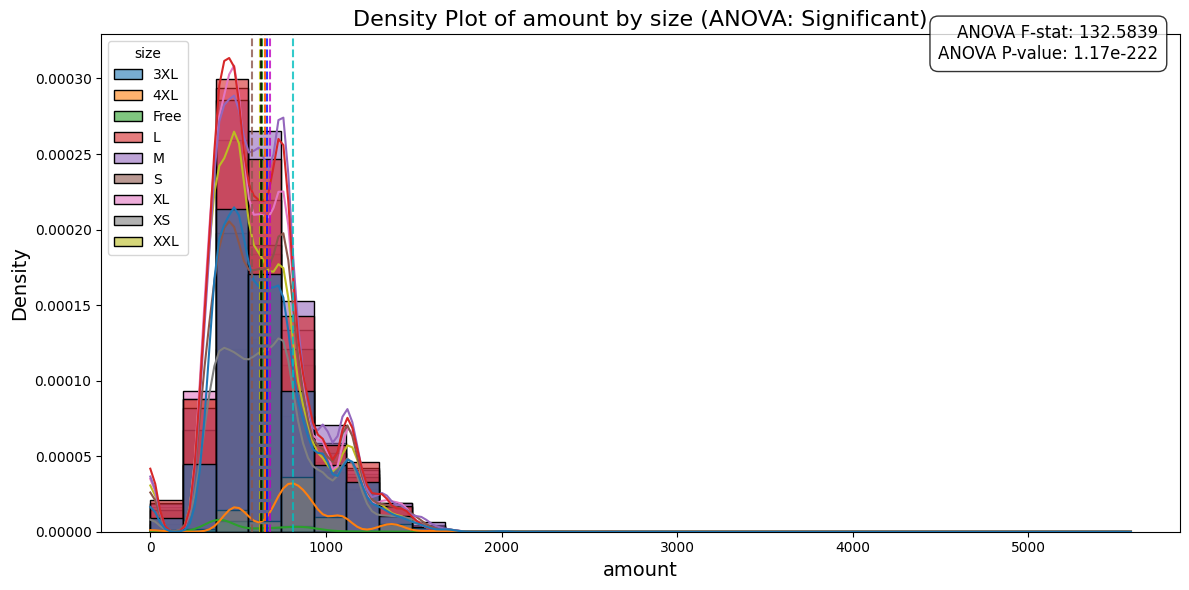


--- ANOVA (qty_cat vs amount) ---
F-statistic: 1033.6369
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


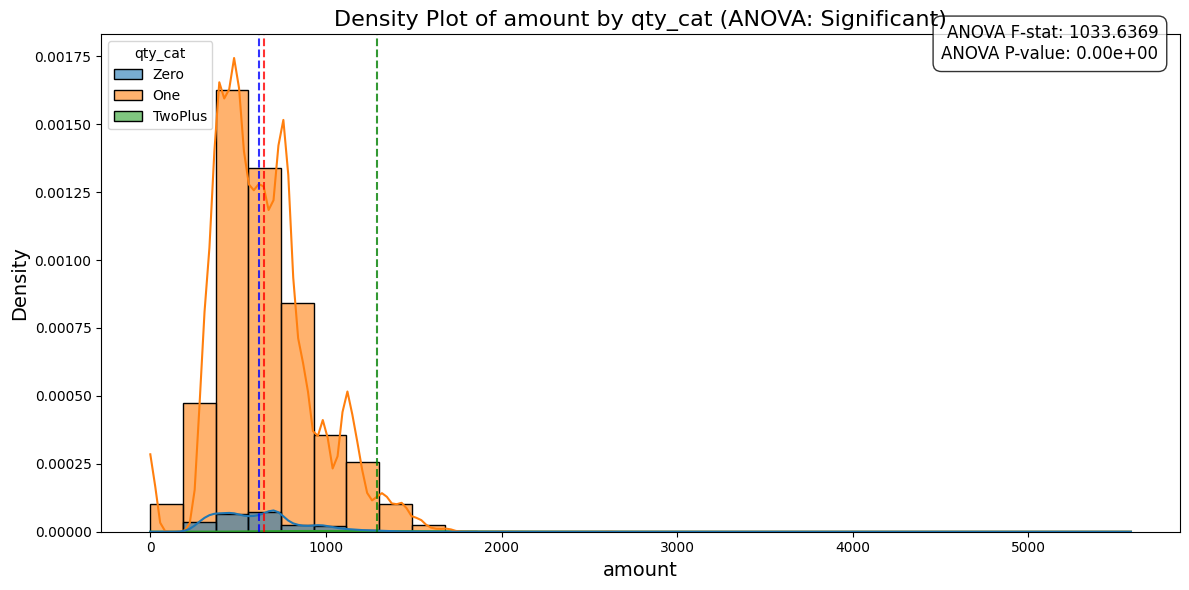

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# -------------------------------------------------------------
# 1. Settings
# -------------------------------------------------------------
# Assumption: 'df' is your working DataFrame
df_to_use = df
TARGET_NUMERIC = "amount"

# Categorical variables to test with ANOVA (expect ≥ 3 groups)
ANOVA_COLS = [
    'category',
    'courier_status',
    'size',
    'qty_cat'
]

# 2. Build a subset without NA in the target column
df_test = df_to_use.dropna(subset=[TARGET_NUMERIC])

# -------------------------------------------------------------
# 3. Function: run ANOVA and draw a density plot
# -------------------------------------------------------------
def run_anova_and_density_plot(df, numeric_col, cat_col):
    """Run one-way ANOVA and plot density (hist + KDE) by the given categorical column."""

    # Drop rows with NA in the categorical column
    df_clean_specific = df.dropna(subset=[cat_col])

    # Get category levels
    categories = df_clean_specific[cat_col].unique()

    if len(categories) < 3:
        print(f"Skipping {cat_col}: Found only {len(categories)} unique categories (ANOVA requires >= 3).")
        return

    # Build groups for ANOVA
    groups = []
    for cat in categories:
        group_data = df_clean_specific[df_clean_specific[cat_col] == cat][numeric_col]
        if len(group_data) >= 2:
            groups.append(group_data)

    if len(groups) < 2:
        print(f"Skipping {cat_col}: Less than 2 valid groups found after data cleaning.")
        return

    # Run one-way ANOVA
    f_stat, p_val = f_oneway(*groups)

    # Print results
    print(f"\n--- ANOVA ({cat_col} vs {numeric_col}) ---")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.5f}")

    is_significant = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Result: {is_significant} difference in mean amount (P < 0.05)")
    print("-" * 50)

    # 4. Density plot (stacked histograms + KDE by category)
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=df_clean_specific,
        x=numeric_col,
        hue=cat_col,
        kde=True,          # overlay density curve
        stat='density',    # y-axis shows density
        alpha=0.6,
        bins=30,
        legend=True
    )

    # Optional: vertical dashed lines at each group's mean
    colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k', 'tab:orange', 'tab:brown']
    for i, cat in enumerate(categories):
        mean_val = df_clean_specific[df_clean_specific[cat_col] == cat][numeric_col].mean()
        plt.axvline(mean_val, color=colors[i % len(colors)], linestyle='--', alpha=0.8)

    # Titles and labels
    title = f'Density Plot of {numeric_col} by {cat_col} (ANOVA: {is_significant})'
    plt.title(title, fontsize=16)
    plt.xlabel(numeric_col, fontsize=14)
    plt.ylabel('Density', fontsize=14)

    # Annotate with statistics
    p_val_display = f"{p_val:.2e}" if p_val < 0.00001 else f"{p_val:.5f}"
    plt.text(
        0.98, 0.95,
        f'ANOVA F-stat: {f_stat:.4f}\nANOVA P-value: {p_val_display}',
        transform=plt.gca().transAxes,
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 5. Execute for all selected categorical variables
# -------------------------------------------------------------
for col in ANOVA_COLS:
    run_anova_and_density_plot(df_test, TARGET_NUMERIC, col)



--- ANOVA (category vs amount) ---
F-statistic: 24123.4980
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


/tmp/ipython-input-2018914812.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=numeric_col, data=df_clean_specific, palette="Set3")


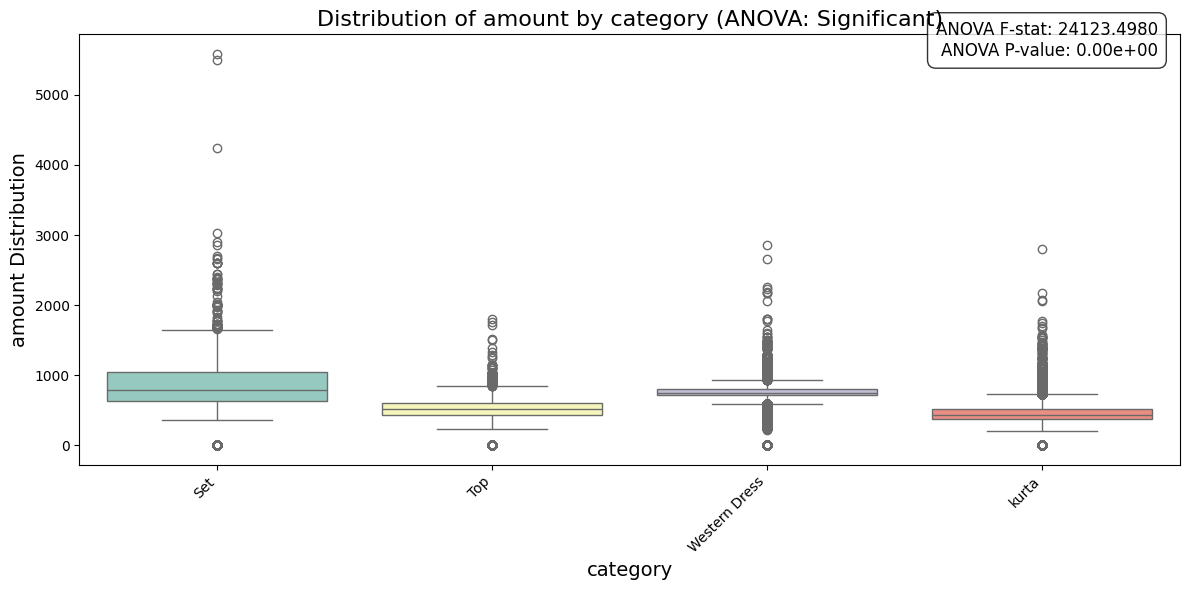

Skipping courier_status: Found only 2 unique categories (ANOVA requires >= 3).

--- ANOVA (size vs amount) ---
F-statistic: 132.5839
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


/tmp/ipython-input-2018914812.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=numeric_col, data=df_clean_specific, palette="Set3")


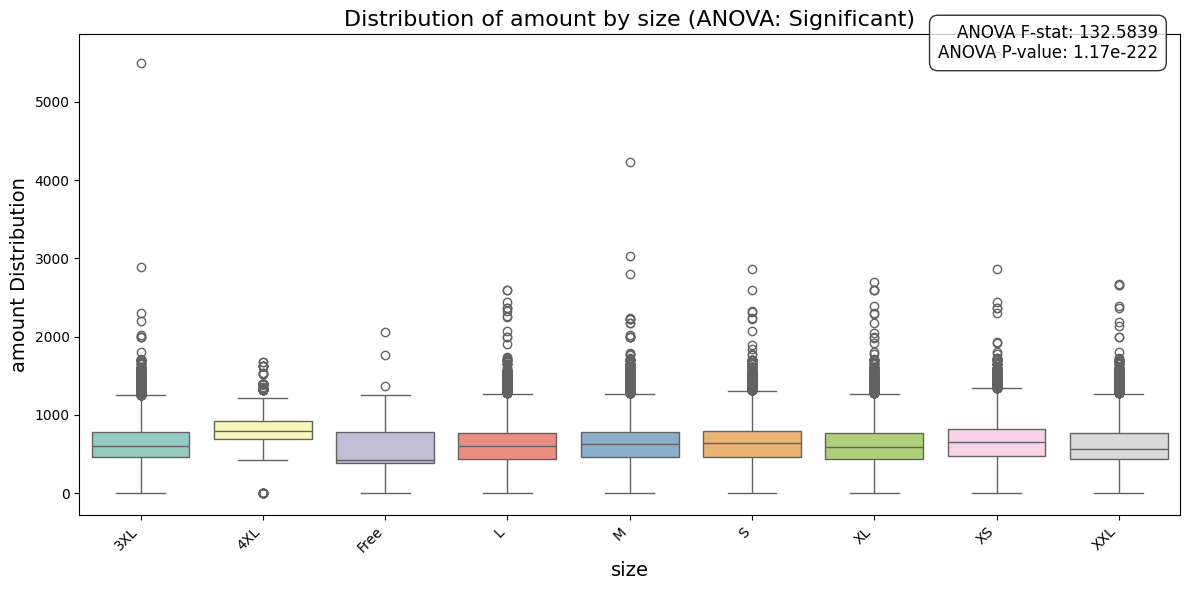


--- ANOVA (qty_cat vs amount) ---
F-statistic: 1033.6369
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


/tmp/ipython-input-2018914812.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=numeric_col, data=df_clean_specific, palette="Set3")


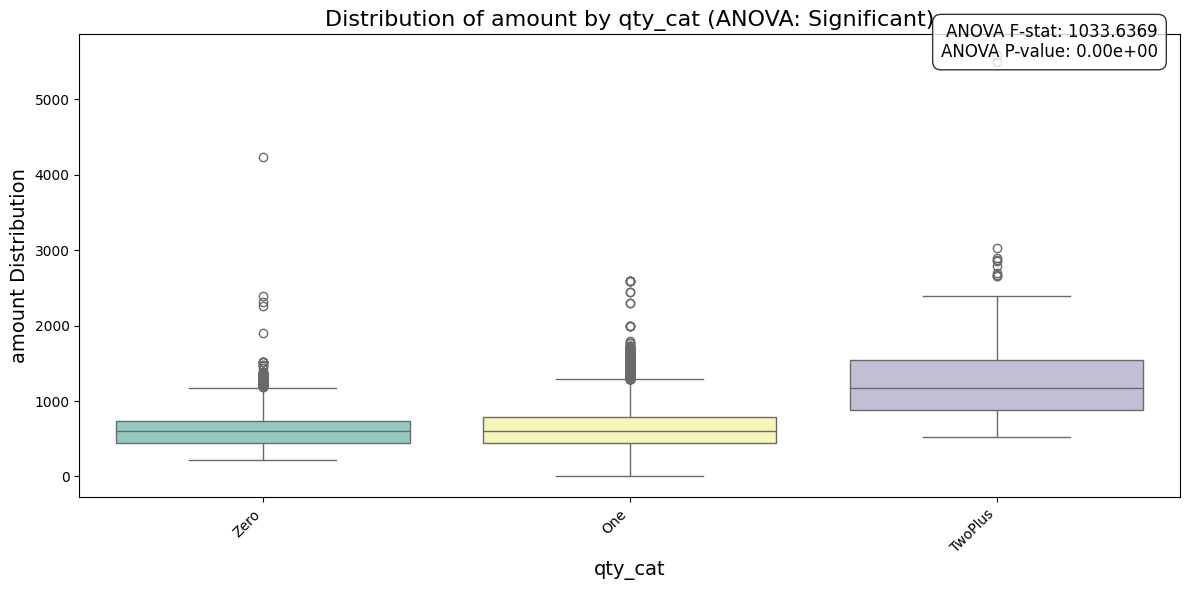

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# -------------------------------------------------------------
# 1. Settings
# -------------------------------------------------------------
# Assumption: 'df' is your working DataFrame and is already loaded.
df_to_use = df
TARGET_NUMERIC = "amount"

# Categorical variables for ANOVA (expecting ≥ 3 groups each)
ANOVA_COLS = [
    'category',
    'courier_status',
    'size',
    'qty_cat'
]

# 2. Build a subset without NA in the target column
df_test = df_to_use.dropna(subset=[TARGET_NUMERIC])

# -------------------------------------------------------------
# 3. Function to run ANOVA and draw a Box Plot
# -------------------------------------------------------------
def run_anova_and_plot(df, numeric_col, cat_col):
    """Run one-way ANOVA and plot a Box Plot for the given categorical column."""

    # Drop rows with NA in the categorical column
    df_clean_specific = df.dropna(subset=[cat_col])

    # Identify category levels present in the current data
    categories = df_clean_specific[cat_col].unique()

    # ANOVA requires at least 3 groups
    if len(categories) < 3:
        print(f"Skipping {cat_col}: Found only {len(categories)} unique categories (ANOVA requires >= 3).")
        return

    # Build per-category groups for ANOVA; ensure each has at least 2 samples
    groups = []
    for cat in categories:
        group_data = df_clean_specific[df_clean_specific[cat_col] == cat][numeric_col]
        if len(group_data) >= 2:
            groups.append(group_data)
        else:
            print(f"Warning: Category '{cat}' in {cat_col} has insufficient data for ANOVA.")

    if len(groups) < 2:
        print(f"Skipping {cat_col}: Less than 2 valid groups found after data cleaning.")
        return

    # Run one-way ANOVA across the groups
    f_stat, p_val = f_oneway(*groups)

    # Print results
    print(f"\n--- ANOVA ({cat_col} vs {numeric_col}) ---")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.5f}")

    is_significant = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Result: {is_significant} difference in mean amount (P < 0.05)")
    print("-" * 50)

    # 4. Box Plot for visual comparison (median, IQR, and outliers)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cat_col, y=numeric_col, data=df_clean_specific, palette="Set3")

    # Titles and labels
    title = f'Distribution of {numeric_col} by {cat_col} (ANOVA: {is_significant})'
    plt.title(title, fontsize=16)
    plt.xlabel(cat_col, fontsize=14)
    plt.ylabel(f'{numeric_col} Distribution', fontsize=14)

    # Rotate category labels for readability
    plt.xticks(rotation=45, ha='right')

    # Annotate with ANOVA statistics on the plot
    p_val_display = f"{p_val:.2e}" if p_val < 0.00001 else f"{p_val:.5f}"
    plt.text(
        0.98, 0.95,
        f'ANOVA F-stat: {f_stat:.4f}\nANOVA P-value: {p_val_display}',
        transform=plt.gca().transAxes,
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()  # ensure the figure renders in notebook environments

# -------------------------------------------------------------
# 5. Execute for all selected categorical variables
# -------------------------------------------------------------
for col in ANOVA_COLS:
    run_anova_and_plot(df_test, TARGET_NUMERIC, col)


✅ 1) ANOVA לפי category

# CHI-Square

/tmp/ipython-input-4220816726.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(df_to_use[c]) or
/tmp/ipython-input-4220816726.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4220816726.py:45: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


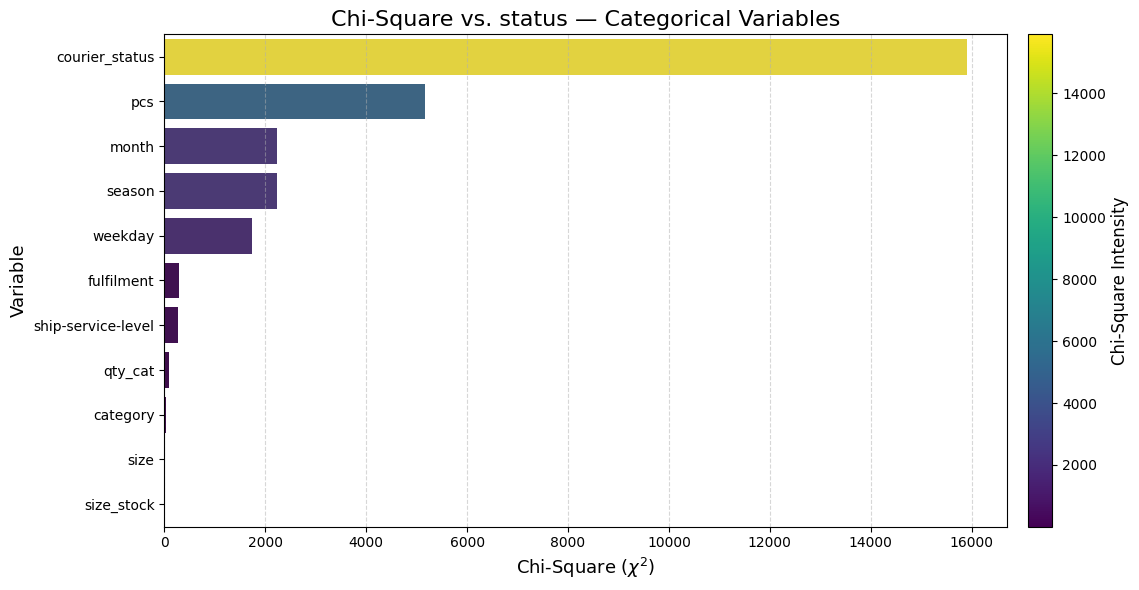

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# ===== Inputs / setup =====
df_to_use = df_cleaned           # use the cleaned DataFrame
target = "status"                # categorical target variable for association testing

# Identify categorical columns (excluding the target itself)
cat_cols = [
    c for c in df_to_use.columns
    if c != target and (
        pd.api.types.is_categorical_dtype(df_to_use[c]) or
        pd.api.types.is_object_dtype(df_to_use[c])
    )
]

results = []

# ===== Chi-square test for each categorical column against the target =====
for col in cat_cols:
    if df_to_use[col].nunique(dropna=True) > 1:  # need at least 2 levels
        contingency = pd.crosstab(df_to_use[col], df_to_use[target], dropna=True)  # contingency table
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:  # valid table (≥2x2)
            chi2_stat, p_val, dof, ex = chi2_contingency(contingency)  # Pearson chi-square
            results.append({"Variable": col, "Chi-Square": chi2_stat, "p_value": p_val})

# ===== Build results table and plot =====
if not results:
    print("No eligible categorical columns for Chi-Square plot.")
else:
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df["Variable"] != target]  # ensure target isn’t plotted as a variable
    results_df.sort_values("Chi-Square", ascending=False, inplace=True, ignore_index=True)

    # ===== Color mapping by chi-square magnitude =====
    norm = plt.Normalize(results_df["Chi-Square"].min(), results_df["Chi-Square"].max())
    cmap = sns.color_palette("viridis", as_cmap=True)  # colormap for bar coloring
    colors = cmap(norm(results_df["Chi-Square"]))

    # ===== Bar chart with gradient coloring =====
    plt.figure(figsize=(12, max(6, 0.5 * len(results_df))))
    sns.barplot(
        data=results_df,
        x="Chi-Square",
        y="Variable",
        palette=colors
    )

    plt.title(f"Chi-Square vs. {target} — Categorical Variables", fontsize=16)
    plt.xlabel(r"Chi-Square ($\chi^2$)", fontsize=13)
    plt.ylabel("Variable", fontsize=13)
    plt.grid(axis="x", linestyle="--", alpha=0.5)

    # === Add a colorbar to indicate intensity ===
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation="vertical", pad=0.02)
    cbar.set_label("Chi-Square Intensity", fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# Assumptions:
# - df_cleaned is your cleaned DataFrame
# - target is a categorical target column (e.g., 'status')
df_to_use = df_cleaned.copy()
target = "status"

# If cat_cols was not defined earlier, auto-detect categorical/object columns (excluding target)
if "cat_cols" not in locals():
    cat_cols = [
        c for c in df_to_use.columns
        if c != target and (
            pd.api.types.is_categorical_dtype(df_to_use[c]) or
            pd.api.types.is_object_dtype(df_to_use[c])
        )
    ]

# Helper: Cramér's V (effect size) with bias correction (Bergsma 2013)
def cramers_v_corrected(confusion: pd.DataFrame) -> float:
    """Compute bias-corrected Cramér's V for any-sized contingency table."""
    chi2, _, _, _ = chi2_contingency(confusion)
    n = confusion.values.sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = confusion.shape
    # Bias correction
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    denom = min((k_corr-1), (r_corr-1))
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2_corr / denom)

# Collect detailed results
results = []

for col in cat_cols:
    # Skip columns with <2 distinct non-null categories
    if df_to_use[col].nunique(dropna=True) <= 1:
        continue

    # Build contingency table (dropna=True drops NA rows from both variables)
    contingency = pd.crosstab(df_to_use[col], df_to_use[target], dropna=True)

    # Must be at least 2x2 to run chi-square
    if contingency.shape[0] <= 1 or contingency.shape[1] <= 1:
        print(f"Skipping Chi-Square Test for {col}: Not enough groups after dropping NA.")
        continue

    # Chi-square test (note: for 2x2 tables, scipy applies Yates’ continuity correction by default)
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency)

    # Basic diagnostics: flag if any expected count is < 5 (Chi-square assumptions)
    expected_min = expected.min() if expected.size else np.nan
    warn_low_expected = expected_min < 5

    # Effect size
    cramer_v = cramers_v_corrected(contingency)

    # Store summary
    results.append({
        "Variable": col,
        "Chi-Square": chi2_stat,
        "p_value": p_val,
        "dof": dof,
        "min_expected": expected_min,
        "low_expected_flag": warn_low_expected,
        "cramers_v": cramer_v,
        "levels_x": contingency.shape[0],
        "levels_y": contingency.shape[1],
        "n": contingency.values.sum()
    })

    # Optional: verbose printout per variable
    print(f"--- Results for: {col} vs {target} ---")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"Degrees of freedom  : {dof}")
    print(f"P-value             : {p_val:.10f}")
    print(f"Cramér's V          : {cramer_v:.4f}")
    if warn_low_expected:
        print("Note: At least one expected cell count < 5; consider Fisher’s exact test (for 2x2) or category grouping.")
    print("-" * 60)

# Create a tidy results table (sorted by ascending p-value)
if results:
    results_df = (
        pd.DataFrame(results)
        .sort_values(["p_value", "Chi-Square"], ascending=[True, False])
        .reset_index(drop=True)
    )
    # Show top rows; you can display/save as needed
    print("\n=== Chi-Square Summary (sorted by p-value) ===")
    print(results_df.head(20))
else:
    print("No eligible categorical columns for Chi-Square test.")


--- Results for: fulfilment vs status ---
Chi-square statistic: 285.7997
p-value: 0.0000000000
--- Results for: ship-service-level vs status ---
Chi-square statistic: 267.7583
p-value: 0.0000000000
--- Results for: category vs status ---
Chi-square statistic: 35.4099
p-value: 0.0000000998
--- Results for: size vs status ---
Chi-square statistic: 8.7301
p-value: 0.3655734808
--- Results for: courier_status vs status ---
Chi-square statistic: 15910.2130
p-value: 0.0000000000
Skipping Chi-Square Test for ship-country: Not enough groups after dropping NA.
--- Results for: month vs status ---
Chi-square statistic: 2229.2989
p-value: 0.0000000000
--- Results for: weekday vs status ---
Chi-square statistic: 1742.1937
p-value: 0.0000000000
--- Results for: pcs vs status ---
Chi-square statistic: 5175.0944
p-value: 0.0000000000
--- Results for: size_stock vs status ---
Chi-square statistic: 8.0756
p-value: 0.4261199956
--- Results for: status vs status ---
Chi-square statistic: 128863.6475
p-va

/tmp/ipython-input-3448897191.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Chi-Square", y="Variable", data=results_df, palette="viridis")


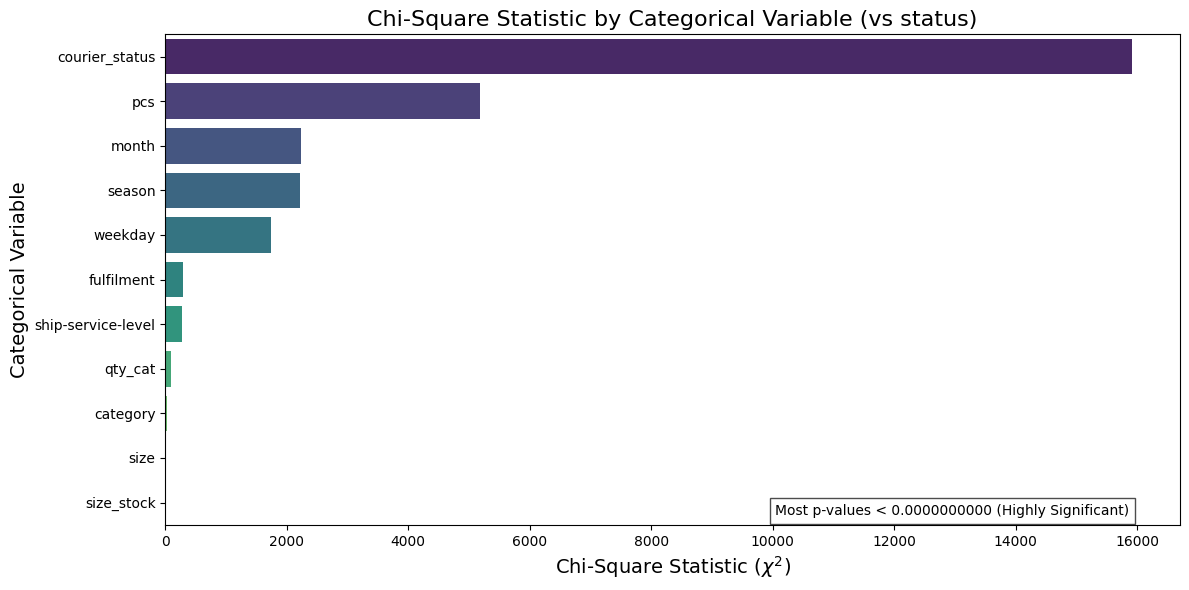

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Manually input the Chi-Square results you computed elsewhere
data = {
    "Variable": [
        "fulfilment",
        "ship-service-level",
        "category",
        "size",
        "courier_status",
        "month",
        "weekday",
        "pcs",
        "size_stock",
        "qty_cat",
        "season"
    ],
    "Chi-Square": [
        285.7997,
        267.7583,
        35.4099,
        8.7301,
        15910.2130,
        2229.2989,
        1742.1937,
        5175.0944,
        8.0756,
        99.8628,
        2225.8092
    ],
    # Corresponding p-values (many are extremely small)
    "p_value": [
        0.0,
        0.0,
        0.0000000998,
        0.3655734808,
        0.0,
        0.0,
        0.0,
        0.0,
        0.4261199956,
        0.0,
        0.0
    ]
}

# Create DataFrame from the results
results_df = pd.DataFrame(data)

# Sort by Chi-Square in descending order for clearer visualization
results_df = results_df.sort_values(by="Chi-Square", ascending=False)

# ==============================================
# Build a horizontal bar chart of Chi-Square statistics
# ==============================================
plt.figure(figsize=(12, 6))
sns.barplot(x="Chi-Square", y="Variable", data=results_df, palette="viridis")

plt.title("Chi-Square Statistic by Categorical Variable (vs status)", fontsize=16)
plt.xlabel("Chi-Square Statistic ($\\chi^2$)", fontsize=14)
plt.ylabel("Categorical Variable", fontsize=14)

# Add a note indicating that most p-values are effectively ~0 (highly significant)
plt.text(
    0.95, 0.02,
    "Most p-values < 1e-10 (Highly Significant)",
    transform=plt.gca().transAxes,
    fontsize=10,
    ha='right',
    bbox=dict(facecolor='white', alpha=0.7)
)

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd
# הנחה: df_to_use הוא ה-DataFrame המנוקה שנוצר קודם
df_to_use = df
target = "day"
cat_cols = df.select_dtypes(include=["object", "category"]).columns
# הנחה: cat_cols הוגדר כראוי (רשימת עמודות קטגוריאליות)

# ==============================================
# 🎲 12. Chi-Square Test for Categorical Variables vs Target
# ==============================================
for col in cat_cols:

    # ודא שהטור מכיל יותר מקטגוריה אחת ושיש מספיק נתונים
    if df_to_use[col].nunique() > 1:

        # יצירת טבלת התלות (Contingency Table)
        contingency = pd.crosstab(df_to_use[col], df_to_use[target], dropna=True)

        # ודא שהטבלה אינה ריקה
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:

            # הרצת מבחן חי בריבוע
            chi2_stat, p_val, dof, ex = chi2_contingency(contingency)

            # הצגת התוצאות המלאות
            print(f"--- Results for: {col} vs {target} ---")
            print(f"Chi-square statistic: {chi2_stat:.4f}")
            print(f"p-value: {p_val:.10f}") # הצגה בדיוק גבוה יותר כדי להבחין אם הערך אינו בדיוק 0

        else:
            print(f"Skipping Chi-Square Test for {col}: Not enough groups after dropping NA.")

/tmp/ipython-input-1859982568.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Chi-Square", y="Variable", data=results_df, palette="viridis")


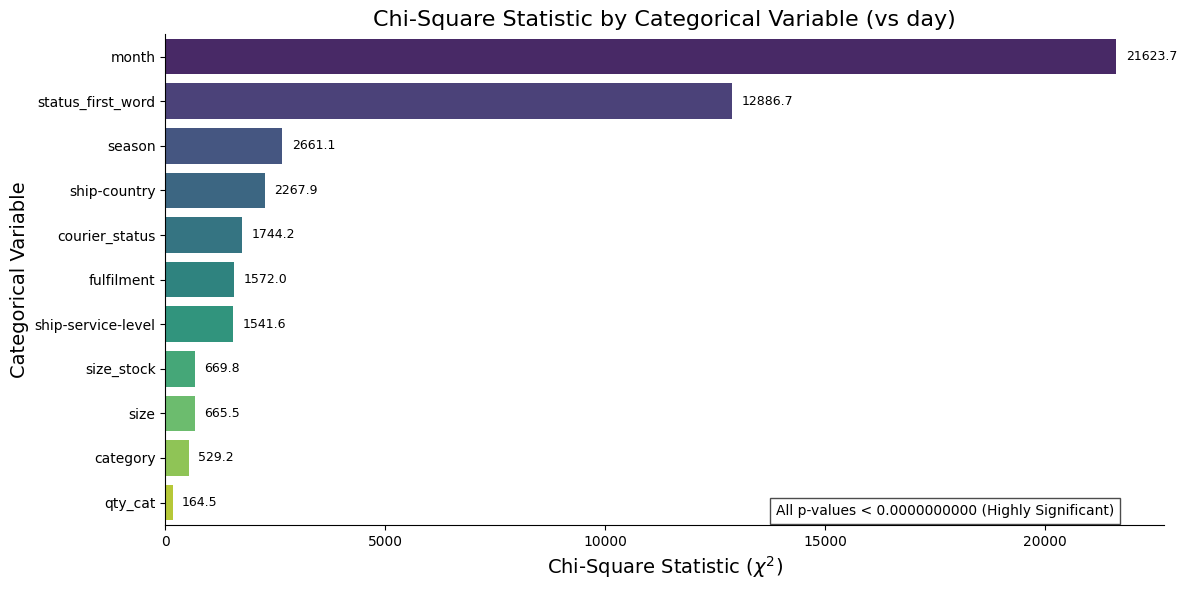

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================
# הכנסת הנתונים החדשים
# ==============================================
data = {
    "Variable": [
        "month",
        "status_first_word",
        "ship-country",
        "season",
        "courier_status",
        "fulfilment",
        "ship-service-level",
        "size_stock",
        "size",
        "category",
        "qty_cat"
    ],
    "Chi-Square": [
        21623.7476,
        12886.7210,
        2267.8885,
        2661.0602,
        1744.1642,
        1571.9648,
        1541.5869,
        669.7582,
        665.5001,
        529.2388,
        164.5462
    ],
    "p_value": [0.0] * 11
}

# יצירת DataFrame ומיון לפי ערך ה-Chi-Square
results_df = pd.DataFrame(data)
results_df = results_df.sort_values(by="Chi-Square", ascending=False)

# ==============================================
# יצירת גרף עמודות
# ==============================================
plt.figure(figsize=(12, 6))
sns.barplot(x="Chi-Square", y="Variable", data=results_df, palette="viridis")

plt.title("Chi-Square Statistic by Categorical Variable (vs day)", fontsize=16)
plt.xlabel("Chi-Square Statistic ($\\chi^2$)", fontsize=14)
plt.ylabel("Categorical Variable", fontsize=14)

# הוספת הערות עם ערכי ה-Chi-Square על כל עמודה
for index, value in enumerate(results_df["Chi-Square"]):
    plt.text(value + max(results_df["Chi-Square"]) * 0.01, index, f"{value:.1f}", va='center', fontsize=9)

# הערה על ערכי ה-p
plt.text(
    0.95, 0.02,
    "All p-values < 0.0000000000 (Highly Significant)",
    transform=plt.gca().transAxes,
    fontsize=10,
    ha='right',
    bbox=dict(facecolor='white', alpha=0.7)
)

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
# --- Map orders by city for a specific amount ---
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm

# Ensure expected columns exist and are strings (normalize types for grouping and geocoding)
df['ship-city_norm'] = df['ship-city_norm'].astype(str)
df['ship-state'] = df['ship-state'].astype(str)

# === 2) Aggregate sales by state + city ===
# Sum total 'amount' per (ship-state, ship-city_norm) and sort by descending sales
sales_by_city = (
    df.groupby(['ship-state', 'ship-city_norm'], as_index=False)['amount']
    .sum()
    .sort_values('amount', ascending=False)
)

# === 3) Geocode each city to get latitude/longitude (uses OpenStreetMap Nominatim) ===
# Note: Geocoding is rate-limited; for many rows consider caching or batching.
geolocator = Nominatim(user_agent="sales_map_india")
tqdm.pandas()  # enable progress bar for apply

def geocode_location(city, state):
    """Return latitude/longitude for '<city>, <state>, India'; None/None if not found or on error."""
    try:
        loc = geolocator.geocode(f"{city}, {state}, India")
        if loc:
            return pd.Series({'lat': loc.latitude, 'lon': loc.longitude})
    except:
        pass
    return pd.Series({'lat': None, 'lon': None})

# Apply geocoding row-wise with a progress bar
sales_by_city[['lat', 'lon']] = sales_by_city.progress_apply(
    lambda row: geocode_location(row['ship-city_norm'], row['ship-state']), axis=1
)

# === 4) Drop rows where geocoding failed (missing coordinates) ===
sales_by_city = sales_by_city.dropna(subset=['lat', 'lon'])

# === 5) Initialize an India-centered interactive map ===
m = folium.Map(location=[22.0, 78.0], zoom_start=5, tiles='cartodbpositron')

# === 6) Add circle markers sized by relative sales volume ===
# Radius scaled up to 25px max; minimum radius enforced for visibility
for _, row in sales_by_city.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=max(3, row['amount'] / sales_by_city['amount'].max() * 25),
        popup=f"""
        <b>{row['ship-city_norm']}</b>, {row['ship-state']}<br>
        Sales: ₹{row['amount']:.2f}
        """,
        color="blue",
        fill=True,
        fill_color="green",
        fill_opacity=0.6
    ).add_to(m)

# === 7) Save to HTML and return the map object (renders inline in notebooks) ===
m.save("sales_map_india.html")
m


100%|██████████| 315/315 [10:15<00:00,  1.95s/it]


#Folium Map: Orders by City
🔹 Circle size = Number of orders
🔹 Color = Delivery status ("Shipped" = Blue, "Unshipped" = Red)

In [ ]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm
from html import escape

# ========= 1) Setup =========
# Convert columns to string type to ensure consistency before grouping and geocoding.
df['ship-city_norm'] = df['ship-city_norm'].astype('string')
df['ship-state'] = df['ship-state'].astype('string')
df['status'] = df['status'].astype('string')

# ========= 2) Summarize by City and Status =========
# Group data by state, city, and status — counting number of orders per combination.
status_by_city = (
    df.groupby(['ship-state', 'ship-city_norm', 'status'], as_index=False)
      .size()
      .rename(columns={'size': 'orders'})
      .sort_values('orders', ascending=False)
)

# Raise an error if no rows found for the status column.
if status_by_city.empty:
    raise ValueError("No rows found for 'status' column. Check column name and values.")

# ========= 3) Geocoding =========
# Use Nominatim (OpenStreetMap) to fetch latitude and longitude for each city.
# tqdm is used to show progress during geocoding.
geolocator = Nominatim(user_agent="orders_map_by_status")
tqdm.pandas()

_geo_cache = {}  # cache results to avoid redundant API calls

def geocode_location(city, state):
    key = (str(city), str(state))
    if key in _geo_cache:
        return _geo_cache[key]
    try:
        loc = geolocator.geocode(f"{city}, {state}, India")
        if loc:
            _geo_cache[key] = pd.Series({'lat': loc.latitude, 'lon': loc.longitude})
            return _geo_cache[key]
    except Exception:
        pass
    # Return None if location not found
    _geo_cache[key] = pd.Series({'lat': None, 'lon': None})
    return _geo_cache[key]

# Apply geocoding to each row (with progress bar)
status_by_city[['lat', 'lon']] = status_by_city.progress_apply(
    lambda row: geocode_location(row['ship-city_norm'], row['ship-state']), axis=1
)

# Remove rows where no coordinates were found
status_by_city = status_by_city.dropna(subset=['lat', 'lon'])

# ========= 4) Color Mapping by Status =========
# Define custom colors for each shipping status.
color_map = {
    'Shipped': '#1f77b4',    # Blue
    'Unshipped': '#d62728'   # Red
}

# ========= 5) Create Map =========
# Initialize a Folium map centered over India.
m = folium.Map(location=[22.0, 78.0], zoom_start=5, tiles='cartodbpositron')

max_orders = status_by_city['orders'].max()  # used to scale circle size proportionally

# ========= 6) Add Circle Markers =========
# Each circle represents a city; radius = number of orders, color = status.
for _, row in status_by_city.iterrows():
    color = color_map.get(row['status'], 'gray')
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=max(3, row['orders'] / max_orders * 25),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            html=f"""
                <b>{escape(row['ship-city_norm'])}</b>, {escape(row['ship-state'])}<br>
                <b>Status:</b> {escape(row['status'])}<br>
                <b>Orders:</b> {int(row['orders'])}
            """,
            max_width=300
        ),
        tooltip=f"{row['ship-city_norm']} — {row['status']} — {int(row['orders'])} orders"
    ).add_to(m)

# ========= 7) Add Legend =========
# Add a static HTML legend showing color meaning for each status.
legend_html = """
<div style="
    position: fixed;
    bottom: 30px; left: 30px; z-index: 9999;
    background: white; padding: 10px 12px; border: 1px solid #ccc; border-radius: 6px;
    box-shadow: 0 2px 6px rgba(0,0,0,.15); font-size: 14px;">
    <b>Status Legend</b><br>
    <span style="display:inline-block;width:12px;height:12px;background:#1f77b4;
           border:1px solid #666;margin-right:6px;vertical-align:middle;"></span> Shipped<br>
    <span style="display:inline-block;width:12px;height:12px;background:#d62728;
           border:1px solid #666;margin-right:6px;vertical-align:middle;"></span> Unshipped
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# ========= 8) Save and Display =========
# Save the map as an HTML file and display it in the notebook.
m.save("orders_map_by_status.html")
m


100%|██████████| 766/766 [10:05<00:00,  1.26it/s]


/tmp/ipython-input-3391620956.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


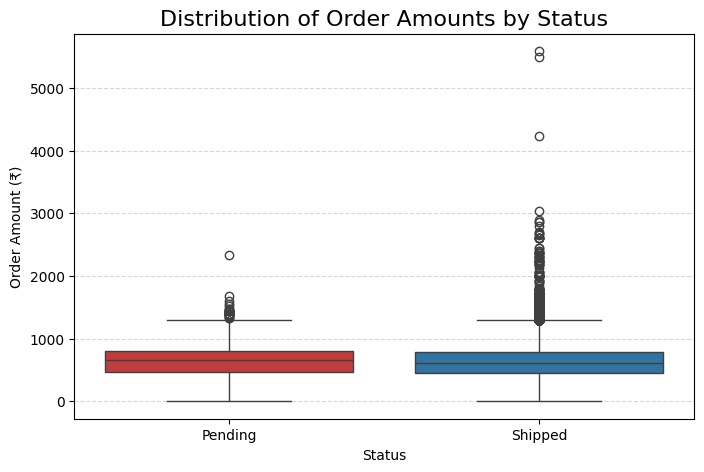

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Note: This boxplot visualizes the distribution of order amounts by shipment status.
# - 'Shipped' orders are colored blue (#1f77b4).
# - 'Pending' orders are colored red (#d62728).
# - If other statuses (e.g., 'Unshipped', 'Cancelled') exist in df['status'],
#   seaborn will raise an error since they are missing from the palette dictionary.
# - Consider adding them to the palette if needed.
# - Grid lines (dashed) help visualize medians across categories.

plt.figure(figsize=(8, 5))
sns.boxplot(
    x='status',
    y='amount',
    data=df,
    palette={'Shipped': '#1f77b4', 'Pending': '#d62728'}
)

plt.title("Distribution of Order Amounts by Status", fontsize=16)
plt.xlabel("Status")
plt.ylabel("Order Amount (₹)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
